In [1]:
# For inline plotting
%matplotlib inline

# For auto reloading
%load_ext autoreload
%autoreload 2


In [2]:
import pickle
from pathlib import Path

from mab import GleapAgent, GleapEpsilonGreedyAgent, UcbAgent, UniformlyRandomAgent
import simulation_config


# Load all the simulation objects
date = "20220713_201857"
simulation_list = []
pathlist = Path("./simulations_data/lv/{:s}".format(date)).glob('*.pkl')
for path in pathlist:
    with open(path, "rb") as f:
        simulation_list.append(pickle.load(f))


# Sort the simulation list
def value_func(simulation_index):
    simulation = simulation_list[simulation_index]
    env = simulation.env
    agent = simulation.agent
    
    # Assume that the parameters are smaller than max_param
    max_param = 1000000.0
    value = 0.0
    if isinstance(agent, GleapAgent):
        value += 4 * max_param
        value += env.latency_std
        
        if env.latency_std < 1.0:
            agent.name = "$\mathbf{{\sigma = {:.1f}}}$".format(env.latency_std)
        else:
            agent.name = "$\mathbf{{\sigma = {:d}}}$".format(int(env.latency_std))
    elif isinstance(agent, GleapEpsilonGreedyAgent):
        value += 3 * max_param
        value += agent.epsilon
    elif isinstance(agent, UcbAgent):
        value += 2 * max_param
        value += agent.gamma
    elif isinstance(agent, UniformlyRandomAgent):
        value += 1 * max_param
        
        agent.name = "Random"
    
    return value


simulation_index_list = [ i for i in range(len(simulation_list)) ]
sorted_simulation_index_list = sorted(simulation_index_list, key=lambda i: value_func(i))
for simulation_index in sorted_simulation_index_list:
    simulation = simulation_list[simulation_index]
    print(simulation.agent.name)


$\mathbf{\sigma = 1}$
$\mathbf{\sigma = 10}$
$\mathbf{\sigma = 20}$
$\mathbf{\sigma = 30}$
$\mathbf{\sigma = 40}$
$\mathbf{\sigma = 50}$
$\mathbf{\sigma = 60}$
$\mathbf{\sigma = 70}$
$\mathbf{\sigma = 80}$
$\mathbf{\sigma = 90}$


In [3]:
import math
from pathlib import Path
import shutil

import numpy as np
import matplotlib
print("matplotlib.__version__:", matplotlib.__version__)
print('Default backend: ' + matplotlib.get_backend())
# matplotlib.use("module://mplcairo.base")
print('Backend is now ' + matplotlib.get_backend())
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from mab import GleapAgent, GleapEpsilonGreedyAgent


def calculate_metrics(simulation_index):
    simulation = simulation_list[simulation_index]
    
    # For reward
    time_averaged_compound_reward_array = np.mean(simulation.time_averaged_compound_reward_2darray, axis=0)
    
    # For regret
    time_averaged_regret_array = np.mean(simulation.time_averaged_regret_2darray, axis=0)
    cumulative_regret_array = np.mean(simulation.cumulative_regret_2darray, axis=0)
    
    # For time-averaged total prediction accuracy
    time_averaged_total_prediction_accuracy_array = np.mean(simulation.time_averaged_total_prediction_accuracy_2darray, axis=0)
    time_averaged_user_satisfaction_array = np.mean(simulation.time_averaged_user_satisfaction_2darray, axis=0)
    
    # For queue length
    if isinstance(simulation.agent, (GleapAgent, GleapEpsilonGreedyAgent)):
        q_array = np.mean(simulation.q_2darray, axis=0)
    else:
        q_array = None
    
    # For time-averaged total prediction latency
    time_averaged_total_prediction_latency_array = np.mean(simulation.time_averaged_total_prediction_latency_2darray, axis=0)
    
    # For time-averaged energy consumption
    time_averaged_energy_consumption_array = np.mean(simulation.time_averaged_energy_consumption_2darray, axis=0)
    
    return {\
            "time_averaged_compound_reward_array": time_averaged_compound_reward_array,\
            "time_averaged_regret_array": time_averaged_regret_array,\
            "cumulative_regret_array": cumulative_regret_array,\
            "time_averaged_total_prediction_accuracy_array": time_averaged_total_prediction_accuracy_array,\
            "time_averaged_user_satisfaction_array": time_averaged_user_satisfaction_array,
            "q_array": q_array,\
            "time_averaged_total_prediction_latency_array": time_averaged_total_prediction_latency_array,\
            "time_averaged_energy_consumption_array": time_averaged_energy_consumption_array\
           }


def plot_lv_simulations():
    # mkdir
    figure_path = Path("./simulations_data/lv/{:s}/figures".format(date))
    figure_path.mkdir(parents=True, exist_ok=True)
    shutil.rmtree(figure_path)
    figure_path.mkdir(parents=True, exist_ok=True)
    chinese_figure_path = Path("./simulations_data/lv/{:s}/chinese_figures".format(date))
    chinese_figure_path.mkdir(parents=True, exist_ok=True)
    shutil.rmtree(chinese_figure_path)
    chinese_figure_path.mkdir(parents=True, exist_ok=True)
    
    
    num_simulations = len(sorted_simulation_index_list)
    latency_std_array = np.zeros(num_simulations, dtype=float)
    converged_time_averaged_compound_reward_array = np.zeros(num_simulations, dtype=float)
    converged_time_averaged_regret_array = np.zeros(num_simulations, dtype=float)
    converged_time_averaged_total_prediction_accuracy_array = np.zeros(num_simulations, dtype=float)
    converged_time_averaged_user_satisfaction_array = np.zeros(num_simulations, dtype=float)
    converged_time_averaged_total_prediction_latency_array = np.zeros(num_simulations, dtype=float)
    converged_q_array = np.zeros(num_simulations, dtype=float)
    for index, simulation_index in enumerate(sorted_simulation_index_list):
        latency_std_array[index] = simulation_list[simulation_index].env.latency_std
        
        metrics = calculate_metrics(simulation_index)
        time_averaged_compound_reward_array = metrics["time_averaged_compound_reward_array"]
        time_averaged_regret_array = metrics["time_averaged_regret_array"]
        time_averaged_total_prediction_accuracy_array = metrics["time_averaged_total_prediction_accuracy_array"]
        time_averaged_user_satisfaction_array = metrics["time_averaged_user_satisfaction_array"]
        time_averaged_total_prediction_latency_array = metrics["time_averaged_total_prediction_latency_array"]
        q_array = metrics["q_array"]
        converged_time_averaged_compound_reward_array[index] = time_averaged_compound_reward_array[-1]
        converged_time_averaged_regret_array[index] = time_averaged_regret_array[-1]
        converged_time_averaged_total_prediction_accuracy_array[index] = time_averaged_total_prediction_accuracy_array[-1]
        converged_time_averaged_user_satisfaction_array[index] = time_averaged_user_satisfaction_array[-1]
        converged_time_averaged_total_prediction_latency_array[index] = time_averaged_total_prediction_latency_array[-1]
        converged_q_array[index] = q_array[-1]
    
    
    num_round = simulation_list[0].num_round
    MARK_EVERY = (num_round // 10, num_round // 5)
    MARKER_SIZE = 25.0
    MARKER_SIZE_CHINESE = 14.0
    LINE_WIDTH = 6.0
    LINE_WIDTH_CHINESE = 3.0
    FONT_SIZE = 36.0
    FONT_SIZE_CHINESE = 32.0
    FONT_SIZE_TICK = 32.0
    FONT_SIZE_TICK_CHINESE = 26.0
    FONT_SIZE_TICK_OFFSET_TEXT = 28.0
    FONT_SIZE_TICK_OFFSET_TEXT_CHINESE = 24.0
    FIG_SIZE = (16,9)
    FIG_SIZE_CHINESE = (8,6)
    DPI = 120
    DPI_CHINESE = 300
    GRID = True
    GRID_LINE_STYLE = (0,(8,4))
    FONT_WEIGHT = "normal"
    CHINESE_FONT_WEIGHT = "normal"
    if CHINESE_FONT_WEIGHT == "bold":
        CHINESE_FP = fm.FontProperties(fname='./font/source_han_serif_sc_bold.otf', math_fontfamily="stix")
    else:
        CHINESE_FP = fm.FontProperties(fname='./font/source_han_serif_sc_regular.otf', math_fontfamily="stix")
    SAVE_CHINESE_PDF = True
    
    
    ##########################################################################################
    # Beginning for the converged time-averaged compound reward
    
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=DPI)
    ax.plot(latency_std_array, converged_time_averaged_compound_reward_array, 'o', markevery=1, linestyle='-', color="#0072B2", label="Converged Average Reward", markersize=MARKER_SIZE, linewidth=LINE_WIDTH)
    plt.grid(GRID, linestyle=GRID_LINE_STYLE)
#     plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.xaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT, fontweight=FONT_WEIGHT)
    plt.setp(ax.yaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT, fontweight=FONT_WEIGHT)
    ax.set_xlabel(r'Latency Standard Deviation $\sigma$', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    ax.set_ylabel(r'Converged Average Reward', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    fig.tight_layout()
    # Save the figure
    fig.savefig('./simulations_data/lv/{:s}/figures/fig_lv_simulations_reward.png'.format(date), format='png', bbox_inches='tight')
    fig.savefig('./simulations_data/lv/{:s}/figures/fig_lv_simulations_reward.pdf'.format(date), format='pdf', bbox_inches='tight')
    
    # For the Chinese version
    fig, ax = plt.subplots(figsize=FIG_SIZE_CHINESE, dpi=DPI_CHINESE)
    ax.plot(latency_std_array, converged_time_averaged_compound_reward_array, 'o', markevery=1, linestyle='-', color="#0072B2", label="Converged Average Reward", markersize=MARKER_SIZE_CHINESE, linewidth=LINE_WIDTH_CHINESE)
    plt.grid(GRID, linestyle=GRID_LINE_STYLE)
#     plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.xaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.yaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    ax.set_xlabel(r'时延标准差 $\sigma$', fontsize=FONT_SIZE_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    ax.set_ylabel(r'平均奖励', fontsize=FONT_SIZE_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    fig.tight_layout()
    # Save the figure
    fig.savefig('./simulations_data/lv/{:s}/chinese_figures/fig_lv_simulations_reward.png'.format(date), format='png', bbox_inches='tight')
    if SAVE_CHINESE_PDF:
        fig.savefig('./simulations_data/lv/{:s}/chinese_figures/fig_lv_simulations_reward.pdf'.format(date), format='pdf', bbox_inches='tight')
    
    # Ending for the converged time-averaged compound reward
    ##########################################################################################
    
    
    ##########################################################################################
    # Beginning for the converged time-averaged user satisfaction
    
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=DPI)
    ax.plot(latency_std_array, converged_time_averaged_user_satisfaction_array, 'o', markevery=1, linestyle='-', color="#CC79A7", label="Converged User Satisfaction", markersize=MARKER_SIZE, linewidth=LINE_WIDTH)
    plt.grid(GRID, linestyle=GRID_LINE_STYLE)
#     plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.xaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT, fontweight=FONT_WEIGHT)
    plt.setp(ax.yaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT, fontweight=FONT_WEIGHT)
    ax.set_xlabel(r'Latency Standard Deviation $\sigma$', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    ax.set_ylabel(r'Converged User Satisfaction', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    fig.tight_layout()
    # Save the figure
    fig.savefig('./simulations_data/lv/{:s}/figures/fig_lv_simulations_user_satisfaction.png'.format(date), format='png', bbox_inches='tight')
    fig.savefig('./simulations_data/lv/{:s}/figures/fig_lv_simulations_user_satisfaction.pdf'.format(date), format='pdf', bbox_inches='tight')
    
    # For the Chinese version
    fig, ax = plt.subplots(figsize=FIG_SIZE_CHINESE, dpi=DPI_CHINESE)
    ax.plot(latency_std_array, converged_time_averaged_user_satisfaction_array, 'o', markevery=1, linestyle='-', color="#CC79A7", label="Converged User Satisfaction", markersize=MARKER_SIZE_CHINESE, linewidth=LINE_WIDTH_CHINESE)
    plt.grid(GRID, linestyle=GRID_LINE_STYLE)
#     plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.xaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.yaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
#     xlabel = r'能量预算 $\mathbf{b}$' if CHINESE_FONT_WEIGHT == "bold" else r'能量预算 $b$'
    ax.set_xlabel(r'时延标准差 $\sigma$', fontsize=FONT_SIZE_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    ax.set_ylabel(r'用户满意度', fontsize=FONT_SIZE_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    fig.tight_layout()
    # Save the figure
    fig.savefig('./simulations_data/lv/{:s}/chinese_figures/fig_lv_simulations_user_satisfaction.png'.format(date), format='png', bbox_inches='tight')
    if SAVE_CHINESE_PDF:
        fig.savefig('./simulations_data/lv/{:s}/chinese_figures/fig_lv_simulations_user_satisfaction.pdf'.format(date), format='pdf', bbox_inches='tight')
    
    # Ending for the converged time-averaged user satisfaction
    ##########################################################################################
    
    
    # For the converged time-averaged total prediction accuracy
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=DPI)
    ax.plot(latency_std_array, converged_time_averaged_total_prediction_accuracy_array, 'o', markevery=1, linestyle='-', color="#CC79A7", label="Converged Keyboard Accuracy", markersize=MARKER_SIZE, linewidth=LINE_WIDTH)
    plt.grid(GRID, linestyle=GRID_LINE_STYLE)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    ax.set_xlabel(r'Latency Standard Deviation $\sigma$', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    ax.set_ylabel(r'Converged Prediction Accuracy', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    fig.tight_layout()
    # Save the figure
    fig.savefig('./simulations_data/lv/{:s}/figures/fig_lv_simulations_accuracy.png'.format(date), format='png', bbox_inches='tight')
    fig.savefig('./simulations_data/lv/{:s}/figures/fig_lv_simulations_accuracy.pdf'.format(date), format='pdf', bbox_inches='tight')
    
    ##########################################################################################
    # Beginning for the converged time-averaged response latency
    
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=DPI)
    ax.plot(latency_std_array, converged_time_averaged_total_prediction_latency_array, 'o', markevery=1, linestyle='-', color="#009E73", label="Converged Response Latency", markersize=MARKER_SIZE, linewidth=LINE_WIDTH)
    plt.grid(GRID, linestyle=GRID_LINE_STYLE)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.xaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT, fontweight=FONT_WEIGHT)
    plt.setp(ax.yaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT, fontweight=FONT_WEIGHT)
    ax.set_xlabel(r'Latency Standard Deviation $\sigma$', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    ax.set_ylabel(r'Converged Response Latency', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    fig.tight_layout()
    # Save the figure
    fig.savefig('./simulations_data/lv/{:s}/figures/fig_lv_simulations_response_latency.png'.format(date), format='png', bbox_inches='tight')
    fig.savefig('./simulations_data/lv/{:s}/figures/fig_lv_simulations_response_latency.pdf'.format(date), format='pdf', bbox_inches='tight')
    
    # For the Chinese version
    fig, ax = plt.subplots(figsize=FIG_SIZE_CHINESE, dpi=DPI_CHINESE)
    ax.plot(latency_std_array, converged_time_averaged_total_prediction_latency_array, 'o', markevery=1, linestyle='-', color="#009E73", label="Converged Response Latency", markersize=MARKER_SIZE_CHINESE, linewidth=LINE_WIDTH_CHINESE)
    plt.grid(GRID, linestyle=GRID_LINE_STYLE)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.xaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.yaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    ax.set_xlabel(r'延迟标准差 $\sigma$', fontsize=FONT_SIZE_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    ax.set_ylabel(r'响应延迟', fontsize=FONT_SIZE_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    fig.tight_layout()
    # Save the figure
    fig.savefig('./simulations_data/lv/{:s}/chinese_figures/fig_lv_simulations_response_latency.png'.format(date), format='png', bbox_inches='tight')
    if SAVE_CHINESE_PDF:
        fig.savefig('./simulations_data/lv/{:s}/chinese_figures/fig_lv_simulations_response_latency.pdf'.format(date), format='pdf', bbox_inches='tight')
    
    # Ending for the converged time-averaged response latency
    ##########################################################################################


matplotlib.__version__: 3.5.1
Default backend: module://matplotlib_inline.backend_inline
Backend is now module://matplotlib_inline.backend_inline


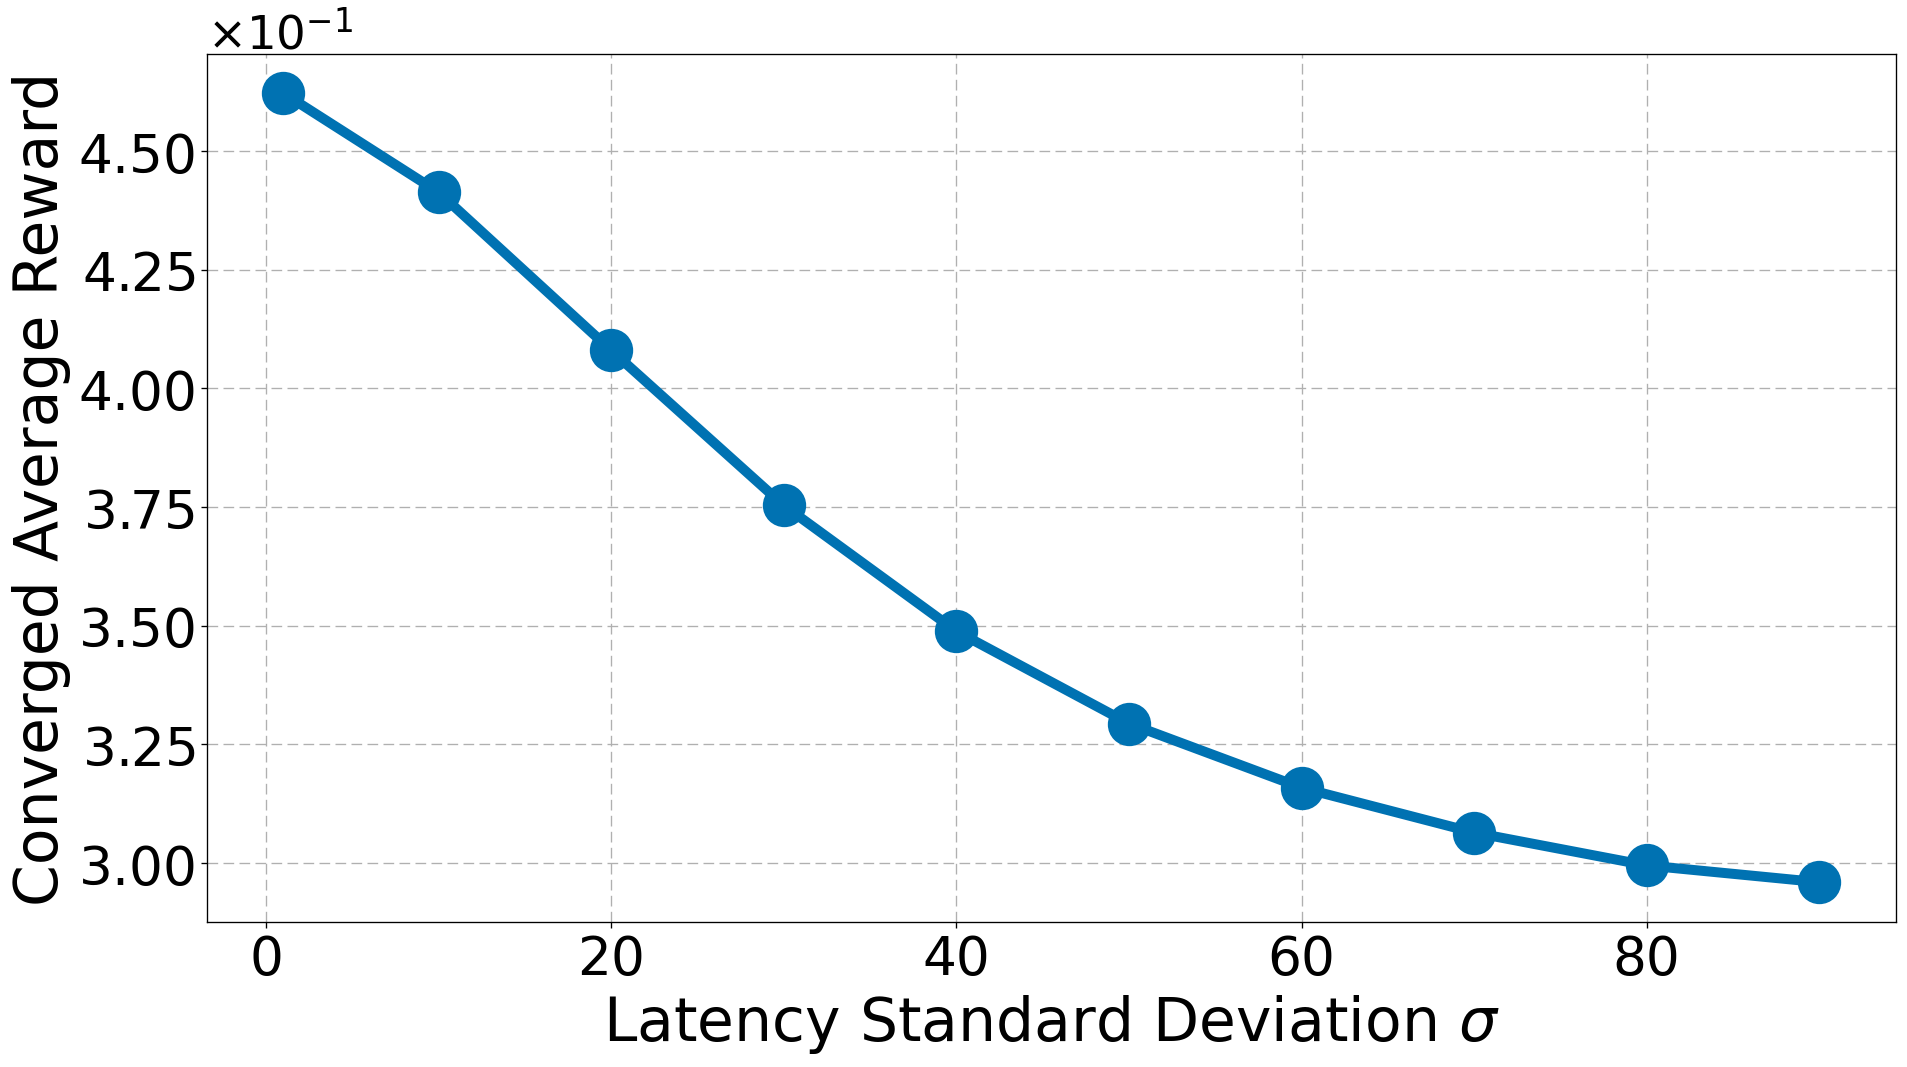

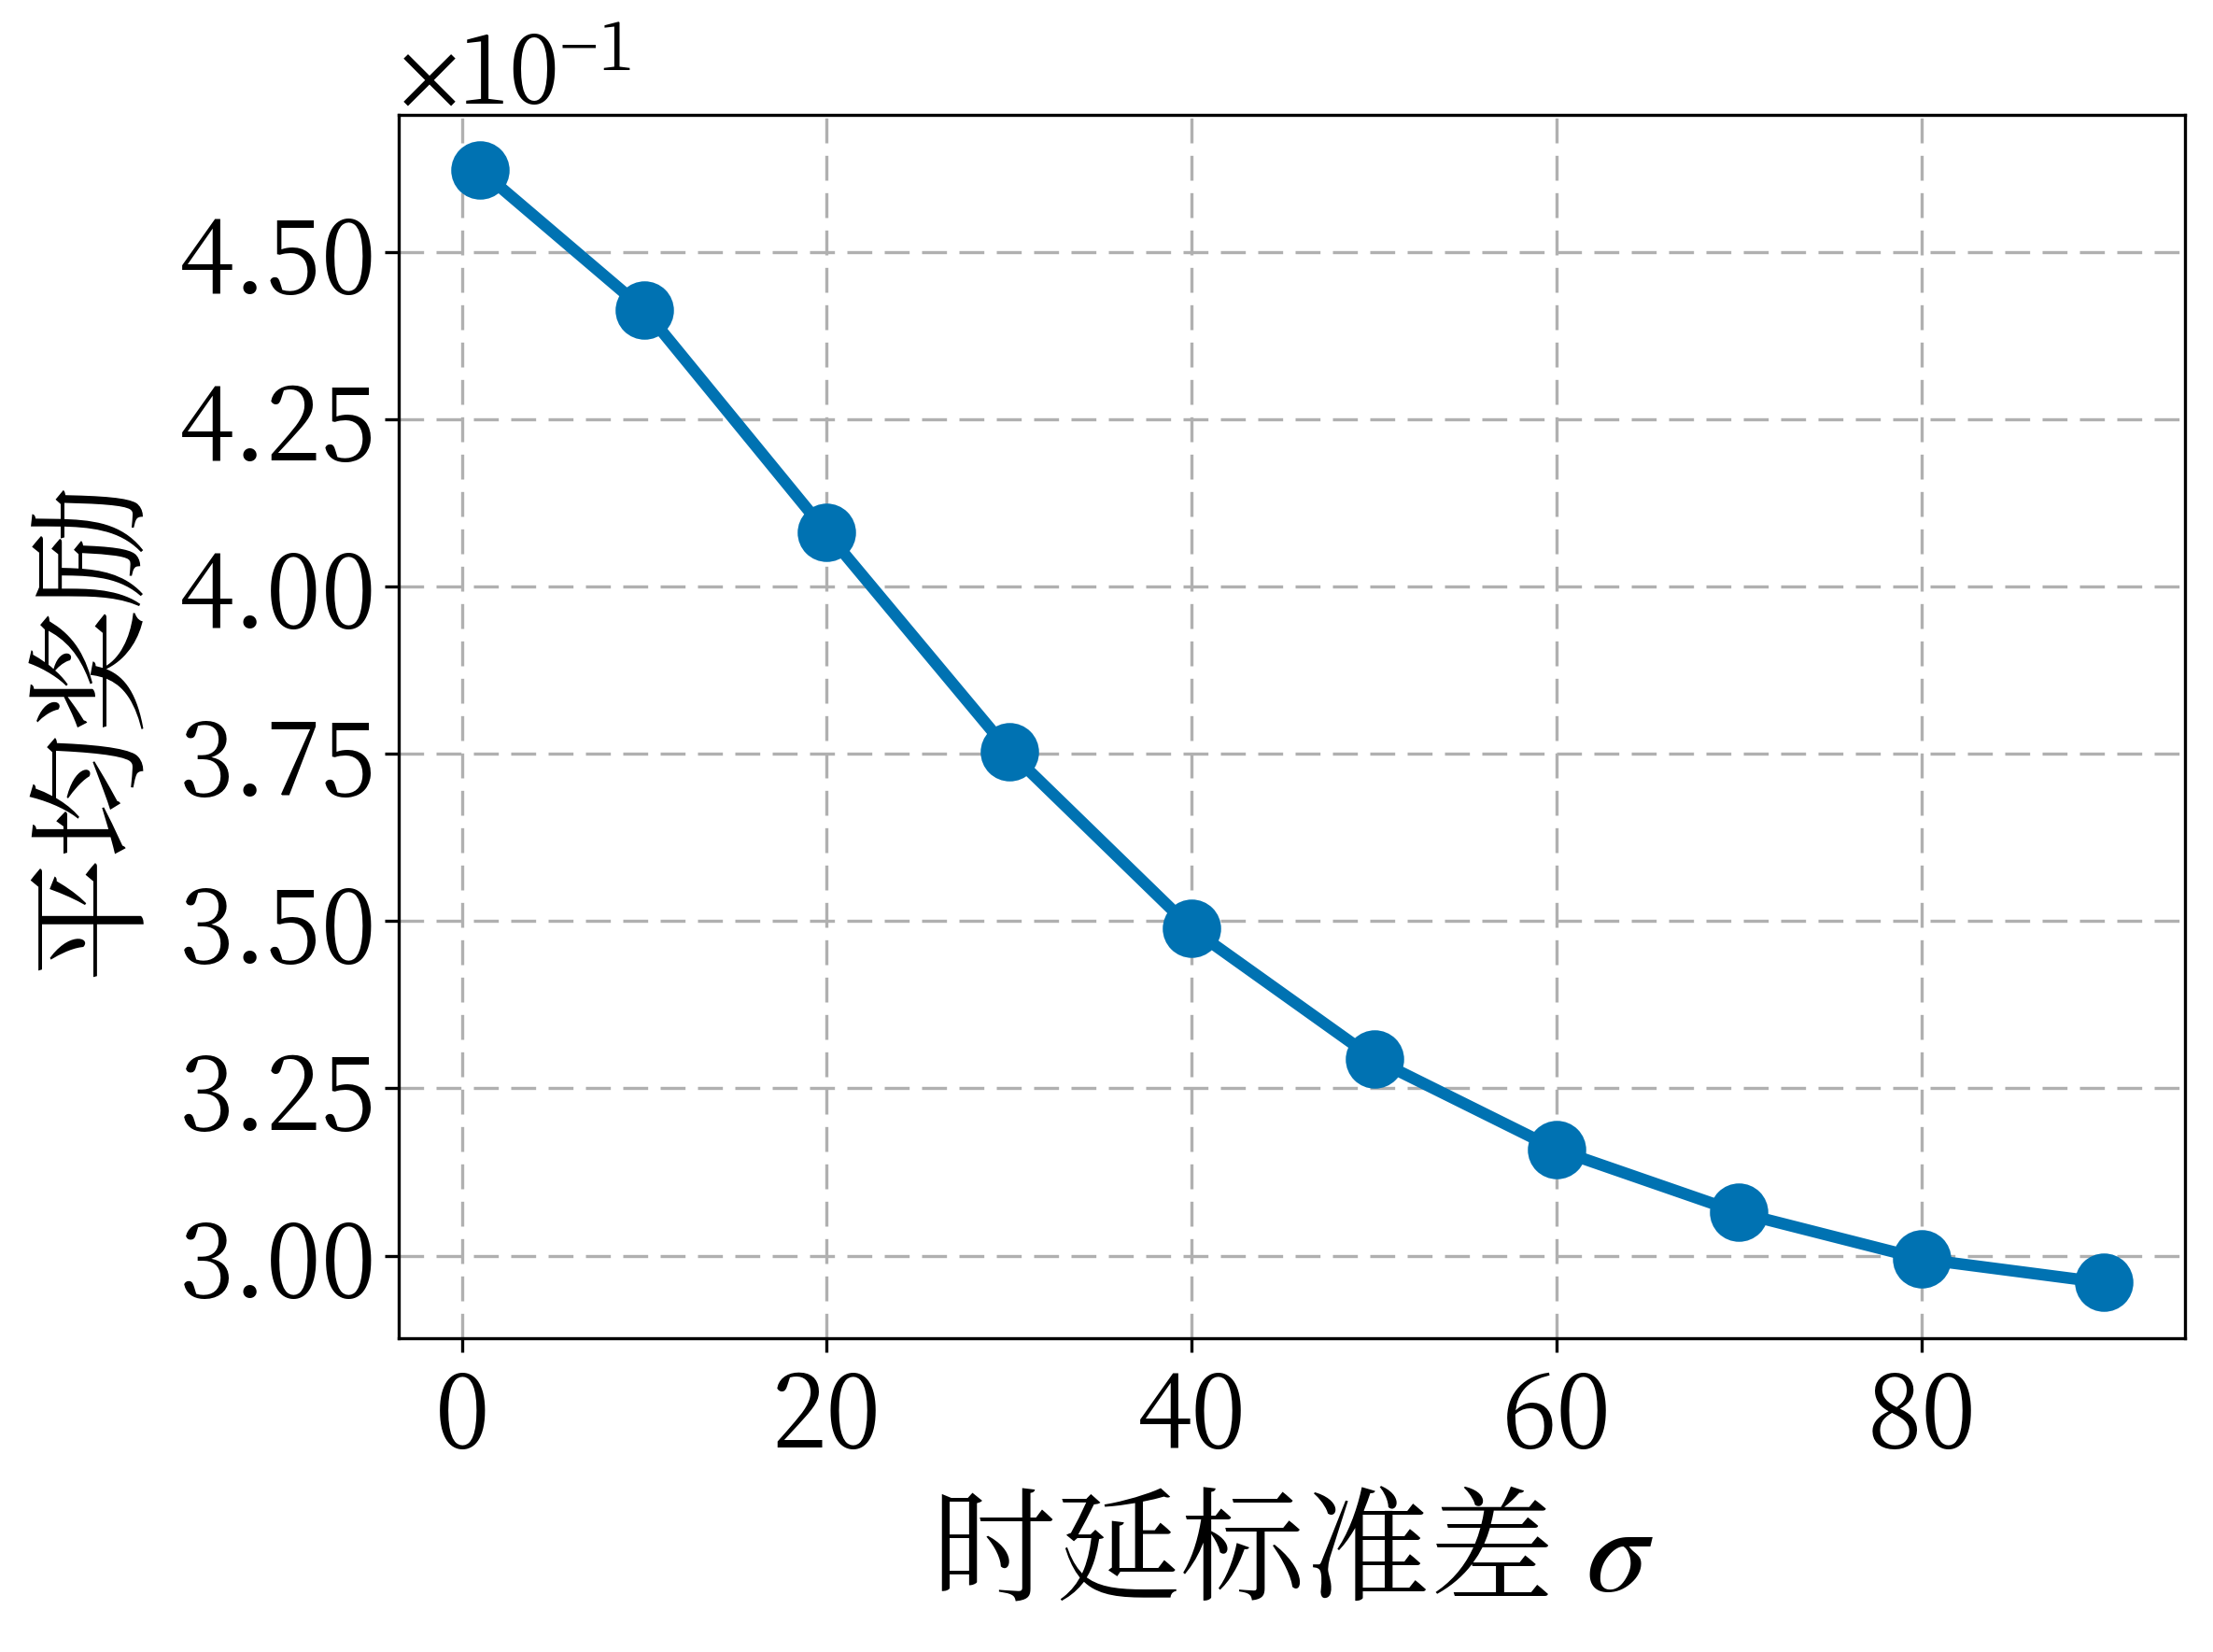

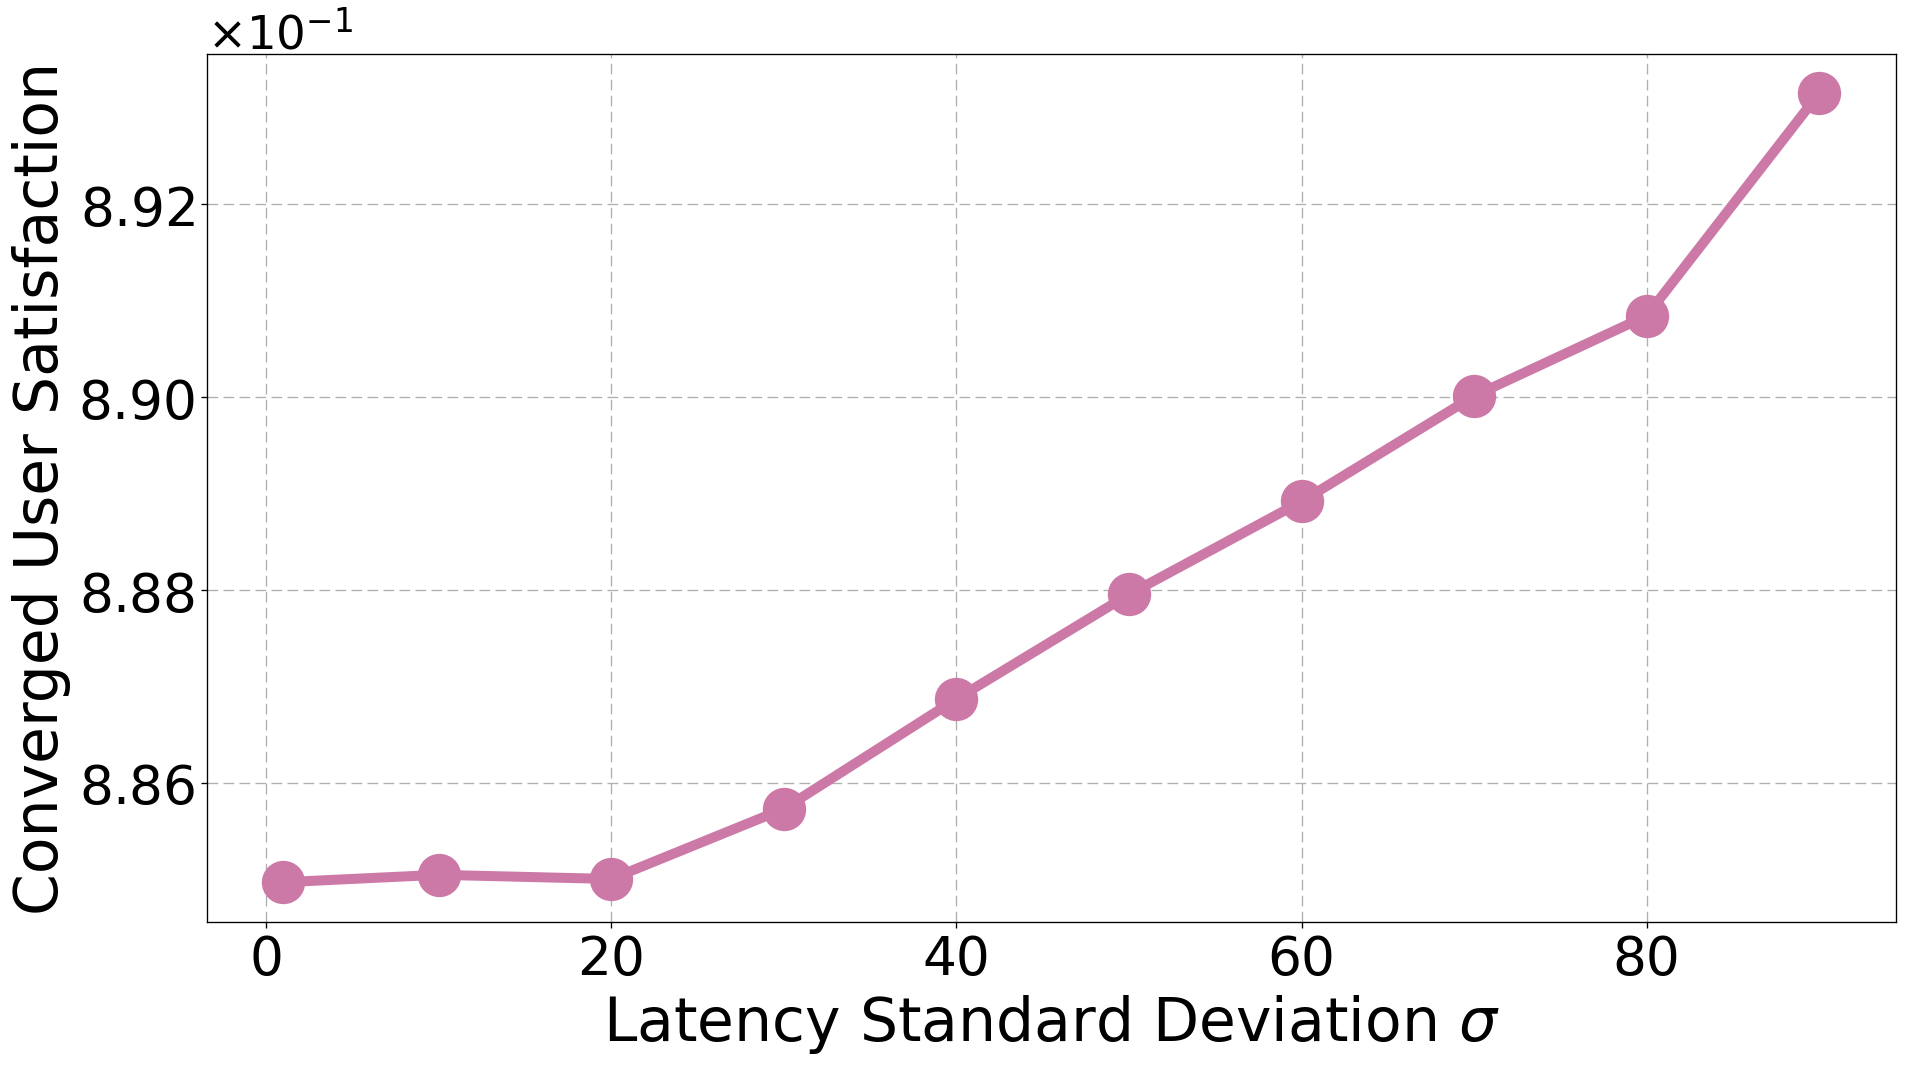

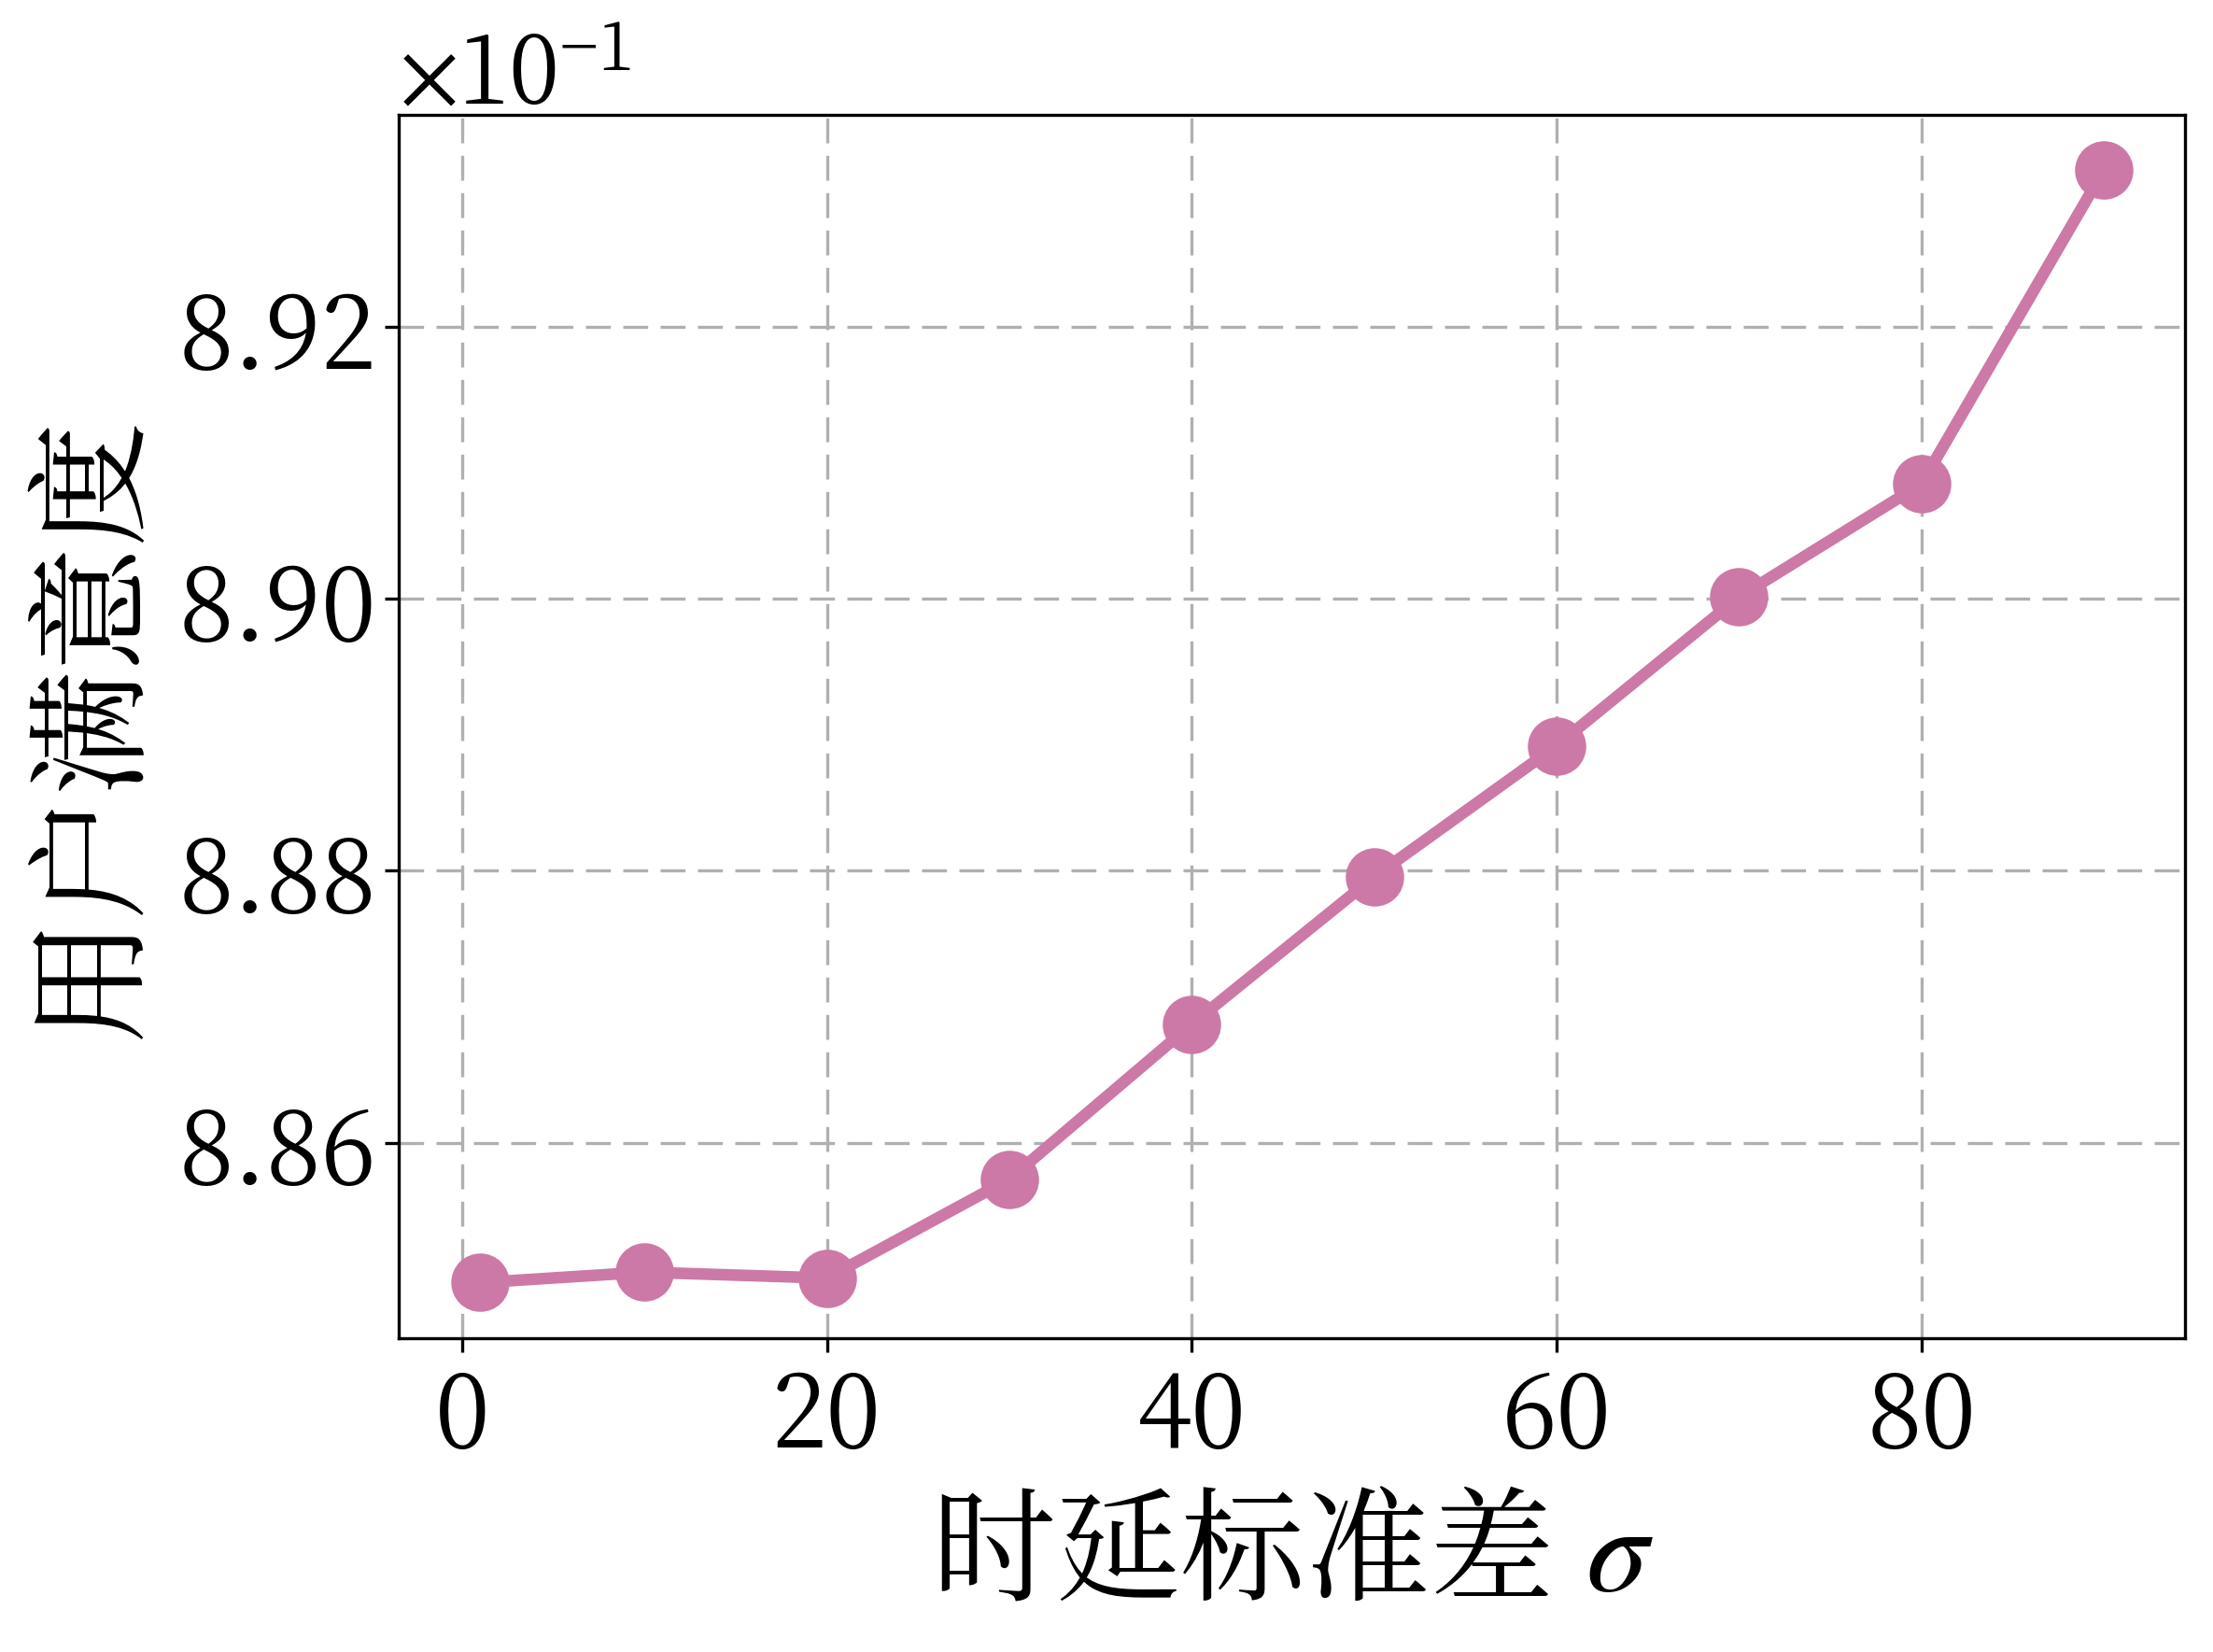

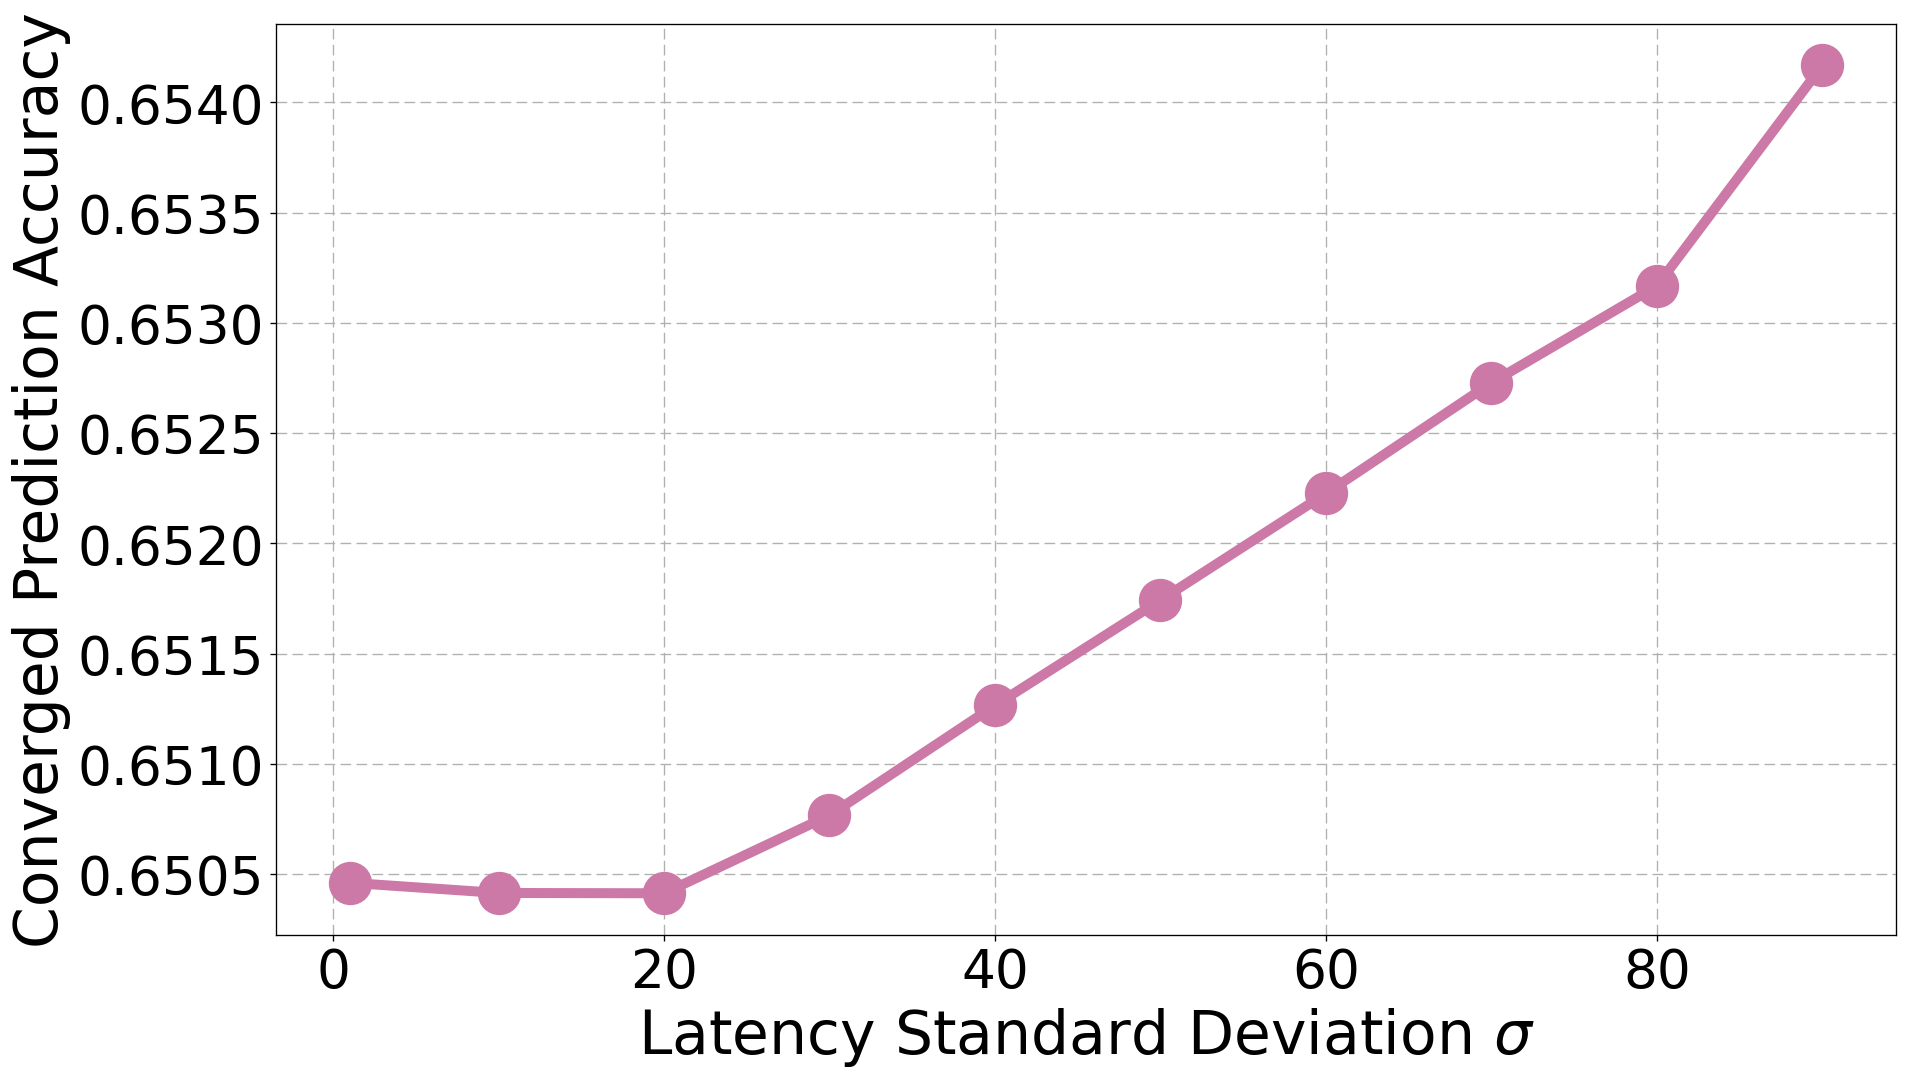

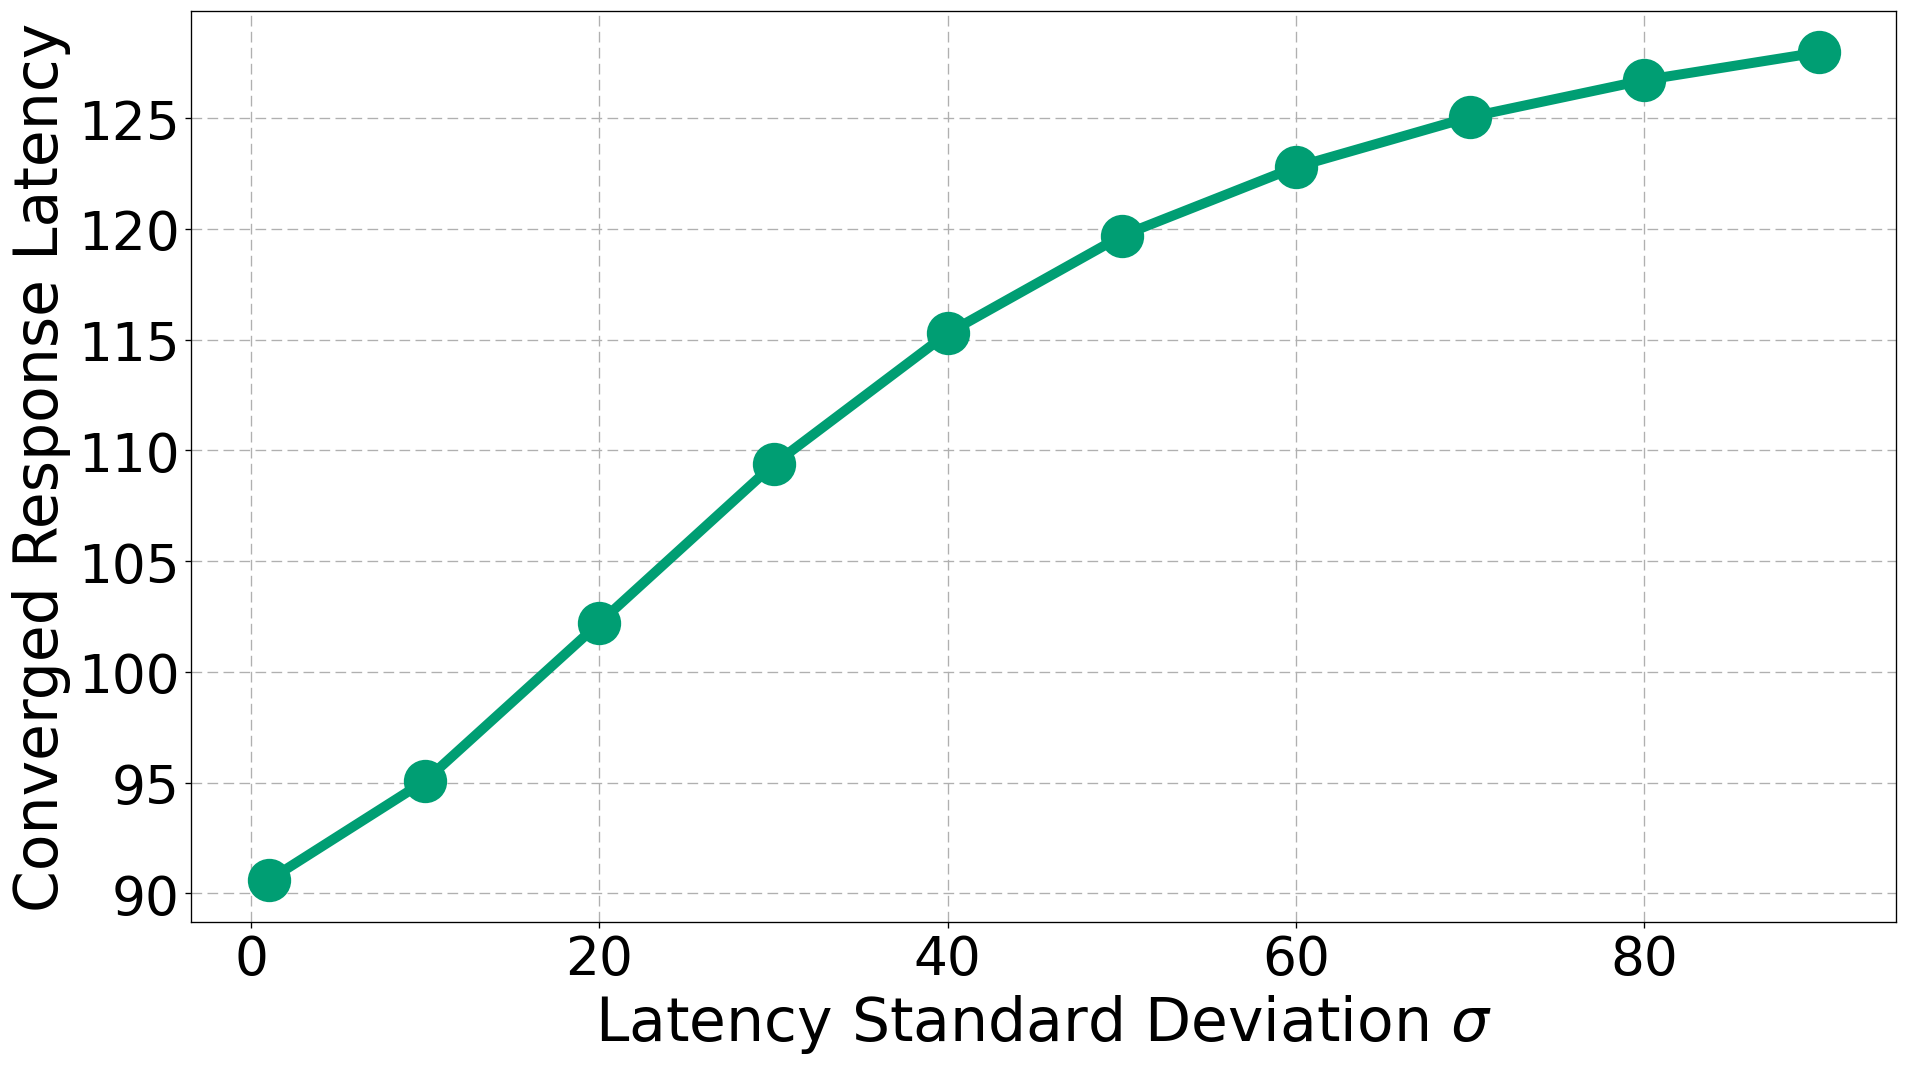

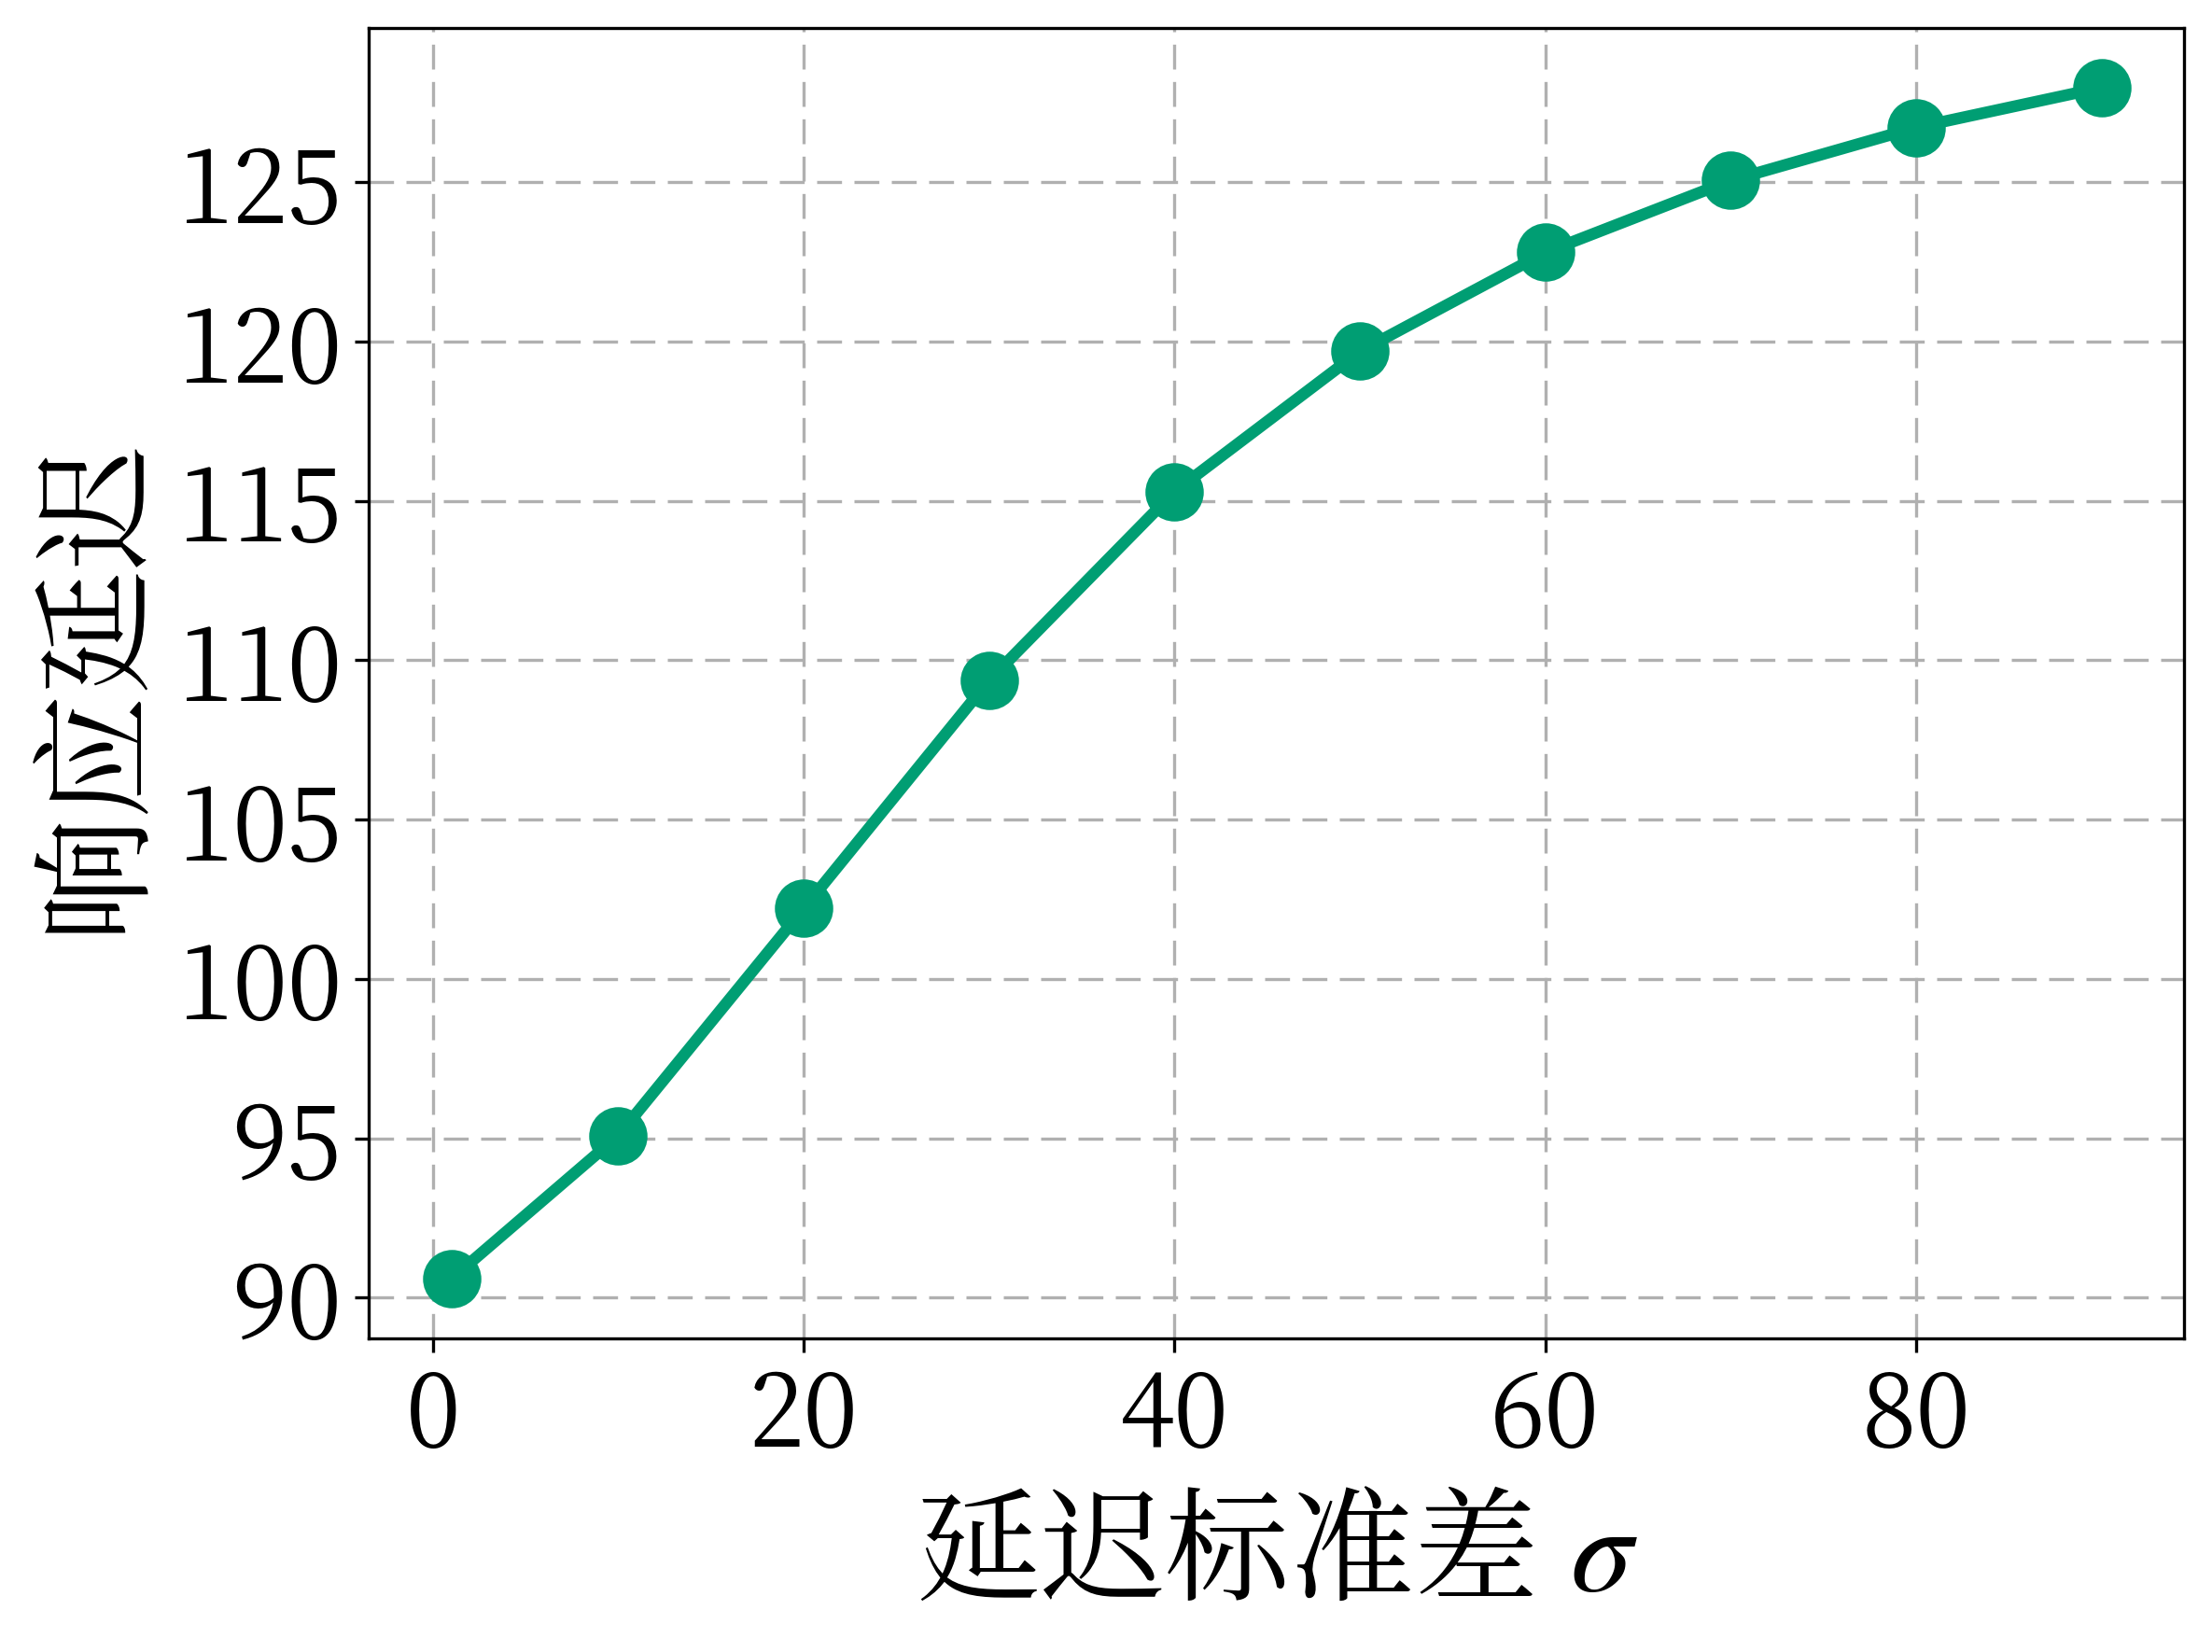

In [4]:
plot_lv_simulations()


In [9]:
def plot():
    # mkdir
    Path("./simulations_data/lv/{:s}/figures".format(date)).mkdir(parents=True, exist_ok=True)
    
    color_list = [ '#D55E00', '#E69F00', '#CC79A7', '#0072B2', '#009E73' ]
    marker_list = [ 'D', 's', 'o', 'v', '*' ]
    MARK_EVERY = (1000, 2000)
    MARKER_SIZE = 25.0
    LINE_WIDTH = 6.0
    FONT_SIZE = 36.0
    FONT_SIZE_TICK = 32.0
    FIG_SIZE = (16,9)
    DPI = 160
    GRID = False
    FONT_WEIGHT = "bold"
    
    time_averaged_regret_array_list = []
    cumulative_regret_array_list = []
    time_averaged_total_prediction_accuracy_array_list = []
    q_array_list = []
    time_averaged_total_prediction_latency_array_list = []
    time_averaged_energy_consumption_array_list = []
    # Only take 5 simulations to plot the normal figures since the colors and markers are limited
    sorted_simulation_index_list_for_normal_plotting = sorted_simulation_index_list[:5]
    for i in sorted_simulation_index_list_for_normal_plotting:
        metrics = calculate_metrics(i)
        
        time_averaged_regret_array_list.append(metrics["time_averaged_regret_array"])
        cumulative_regret_array_list.append(metrics["cumulative_regret_array"])
        time_averaged_total_prediction_accuracy_array_list.append(metrics["time_averaged_total_prediction_accuracy_array"])
        q_array_list.append(metrics["q_array"])
        time_averaged_total_prediction_latency_array_list.append(metrics["time_averaged_total_prediction_latency_array"])
        time_averaged_energy_consumption_array_list.append(metrics["time_averaged_energy_consumption_array"])

    # For time-averaged regret
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=DPI)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    ax.yaxis.get_offset_text().set_fontsize(20)
    ax.yaxis.get_offset_text().set_fontweight(FONT_WEIGHT)
    ax.xaxis.get_offset_text().set_fontsize(20)
    ax.xaxis.get_offset_text().set_fontweight(FONT_WEIGHT)
#     ax.set_yticks([ -0.25, -0.05, 0.15 ])
    plt.locator_params(axis='x', nbins=3)
    for index, time_averaged_regret_array in enumerate(time_averaged_regret_array_list):
        simulation_index = sorted_simulation_index_list[index]
        agent = simulation_list[simulation_index].agent
        ax.plot(range(1, time_averaged_regret_array.shape[0] + 1), time_averaged_regret_array, marker_list[index], markevery=MARK_EVERY, linestyle='-', color=color_list[index], label=agent.name, markersize=MARKER_SIZE, linewidth=LINE_WIDTH)
#     legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), shadow=True, ncol=2, fontsize=20.0)
    legend = ax.legend(shadow=True, prop={ 'size': 32, 'weight': 'bold'})
#     ##############################################################################
#     # For the envelope of the regret bound
#     skip_first = 2
#     regret_bound_envelope_list = np.zeros(time_averaged_regret_array_list[0].shape[0], dtype=float)
#     for t in range(1, regret_bound_envelope_list.shape[0] + 1):
#         regret_bound_envelope_list[t - 1] = 0.1 + 1 * math.sqrt(math.log(t) / t)
#     ax.plot(range(1 + skip_first, regret_bound_envelope_list.shape[0] + 1), regret_bound_envelope_list[skip_first:], linestyle='-.', color="#4d2719", label=r"Envelope of $O(1/V + \sqrt{\log{T}/T})$", linewidth=LINE_WIDTH)
#     ##############################################################################
    plt.grid(GRID)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax.set_xlabel(r'Round ($\mathbf{\times 10^4}$)', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    ax.set_ylabel(r'Avg. Regret ($\mathbf{\times 10^{-1}}$)', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    # Save the figure
#     fig.savefig('./simulations_data/v/{:s}/figures/fig_inference_v_time_averaged_regret.png'.format(date), format='png', bbox_extra_artists=(legend,), bbox_inches='tight')
#     fig.savefig('./simulations_data/v/{:s}/figures/fig_inference_v_time_averaged_regret.eps'.format(date), format='eps', bbox_extra_artists=(legend,), bbox_inches='tight')
    fig.savefig('./simulations_data/lv/{:s}/figures/fig_inference_lv_time_averaged_regret.pdf'.format(date), format='pdf', bbox_extra_artists=(legend,), bbox_inches='tight')
    
    # For cumulative regret
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=DPI)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    for index, cumulative_regret_array in enumerate(cumulative_regret_array_list):
        simulation_index = sorted_simulation_index_list[index]
        agent = simulation_list[simulation_index].agent
        ax.plot(range(1, time_averaged_regret_array.shape[0] + 1), cumulative_regret_array, marker_list[index], markevery=MARK_EVERY, linestyle='-', color=color_list[index], label=agent.name, markersize=MARKER_SIZE, linewidth=LINE_WIDTH)
#     legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), shadow=True, ncol=2, fontsize=20.0)
    legend = ax.legend(shadow=True, prop={ 'size': 32, 'weight': 'bold'})
    plt.grid(GRID)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax.set_xlabel(r'Round ($\mathbf{\times 10^4}$)', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    ax.set_ylabel(r'Cumulative Regret', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    # Save the figure
#     fig.savefig('./simulations_data/v/{:s}/figures/fig_inference_v_cumulative_regret.png'.format(date), format='png', bbox_extra_artists=(legend,), bbox_inches='tight')
#     fig.savefig('./simulations_data/v/{:s}/figures/fig_inference_v_cumulative_regret.eps'.format(date), format='eps', bbox_extra_artists=(legend,), bbox_inches='tight')
    fig.savefig('./simulations_data/lv/{:s}/figures/fig_inference_lv_cumulative_regret.pdf'.format(date), format='pdf', bbox_extra_artists=(legend,), bbox_inches='tight')
    
    # For time-averaged total prediction accuracy
    fig, ax = plt.subplots(figsize=(10,6), dpi=200)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    for index, time_averaged_total_prediction_accuracy_array in enumerate(time_averaged_total_prediction_accuracy_array_list):
        simulation_index = sorted_simulation_index_list[index]
        agent = simulation_list[simulation_index].agent
        ax.plot(range(1, time_averaged_total_prediction_accuracy_array.shape[0] + 1), time_averaged_total_prediction_accuracy_array, marker_list[index], markevery=MARK_EVERY, linestyle='-', color=color_list[index], label=agent.name, markersize=MARKER_SIZE, linewidth=LINE_WIDTH)
#     legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), shadow=True, ncol=2, fontsize=20.0)
    legend = ax.legend(shadow=True, prop={ 'size': 32, 'weight': 'bold'})
    plt.grid(GRID)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax.set_xlabel(r'Round ($\mathbf{\times 10^4}$)', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    ax.set_ylabel(r'Average Prediction Accuracy', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    # Save the figure
#     fig.savefig('./simulations_data/v/{:s}/figures/fig_inference_v_time_averaged_total_prediction_accuracy.png'.format(date), bbox_extra_artists=(legend,), format='png', bbox_inches='tight')
#     fig.savefig('./simulations_data/v/{:s}/figures/fig_inference_v_time_averaged_total_prediction_accuracy.eps'.format(date), bbox_extra_artists=(legend,), format='eps', bbox_inches='tight')
    fig.savefig('./simulations_data/lv/{:s}/figures/fig_inference_lv_time_averaged_total_prediction_accuracy.pdf'.format(date), bbox_extra_artists=(legend,), format='pdf', bbox_inches='tight')
    
    # For queue length
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=DPI)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    ax.yaxis.get_offset_text().set_fontsize(20)
    ax.yaxis.get_offset_text().set_fontweight(FONT_WEIGHT)
    ax.xaxis.get_offset_text().set_fontsize(20)
    ax.xaxis.get_offset_text().set_fontweight(FONT_WEIGHT)
    ax.set_yticks([ 0, 200, 400 ])
#     ax.set_yticklabels(['0.0', '2.0', '4.0'], fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.locator_params(axis='x', nbins=3)
    for index, q_array in enumerate(q_array_list):
        if q_array is None:
            continue
        
        simulation_index = sorted_simulation_index_list[index]
        agent = simulation_list[simulation_index].agent
        ax.plot(range(q_array.shape[0]), q_array, marker_list[index], markevery=MARK_EVERY, linestyle='-', color=color_list[index], label=agent.name, markersize=MARKER_SIZE, linewidth=LINE_WIDTH)
#     legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), shadow=True, ncol=2, fontsize=20.0)
    legend = ax.legend(loc=(0.30, 0.58), shadow=True, ncol=2, prop={ 'size': 32, 'weight': 'bold'})
    plt.grid(GRID)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax.set_xlabel(r'Round ($\mathbf{\times 10^4}$)', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    ax.set_ylabel('Queue Length ($\\mathbf{\\times 10^2}$)\n', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
#     #########################
#     # For inset
#     axins = ax.inset_axes([0.10, 0.25, 0.45, 0.45])
#     for index, q_array in enumerate(q_array_list):
#         if q_array is None:
#             continue
        
#         simulation_index = sorted_simulation_index_list[index]
#         agent = simulation_list[simulation_index].agent
#         axins.plot(range(10, 2000 + 1), q_array[10:2000+1], marker_list[index], markevery=100, linestyle='-', color=color_list[index], label=agent.name, markersize=4.0)
#     x1, x2, y1, y2 = 10, 2000, 0.0, 20.0
#     axins.set_xlim(x1, x2)
#     axins.set_ylim(y1, y2)
# #     axins.set_xticklabels('')
# #     axins.set_yticklabels('')
#     ax.indicate_inset_zoom(axins)
#     #########################
    # Save the figure
#     fig.savefig('./simulations_data/v/{:s}/figures/fig_inference_v_queue_length.png'.format(date), format='png', bbox_extra_artists=(legend,), bbox_inches='tight')
#     fig.savefig('./simulations_data/v/{:s}/figures/fig_inference_v_queue_length.eps'.format(date), format='eps', bbox_extra_artists=(legend,), bbox_inches='tight')
    fig.savefig('./simulations_data/lv/{:s}/figures/fig_inference_lv_queue_length.pdf'.format(date), format='pdf', bbox_extra_artists=(legend,), bbox_inches='tight')
    
    # For time-averaged total prediction latency
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=DPI)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    for index, time_averaged_total_prediction_latency_array in enumerate(time_averaged_total_prediction_latency_array_list):
        simulation_index = sorted_simulation_index_list[index]
        agent = simulation_list[simulation_index].agent
        ax.plot(range(1, time_averaged_total_prediction_latency_array.shape[0] + 1), time_averaged_total_prediction_latency_array, marker_list[index], markevery=MARK_EVERY, linestyle='-', color=color_list[index], label=agent.name, markersize=MARKER_SIZE, linewidth=LINE_WIDTH)
#     legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), shadow=True, ncol=2, fontsize=20.0)
    legend = ax.legend(shadow=True, prop={ 'size': 32, 'weight': 'bold'})
    plt.grid(GRID)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax.set_xlabel(r'Round ($\mathbf{\times 10^4}$)', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    ax.set_ylabel(r'Average Prediction Latency', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    # Save the figure
#     fig.savefig('./simulations_data/v/{:s}/figures/fig_inference_v_time_averaged_total_prediction_latency.png'.format(date), format='png', bbox_extra_artists=(legend,), bbox_inches='tight')
#     fig.savefig('./simulations_data/v/{:s}/figures/fig_inference_v_time_averaged_total_prediction_latency.eps'.format(date), format='eps', bbox_extra_artists=(legend,), bbox_inches='tight')
    fig.savefig('./simulations_data/lv/{:s}/figures/fig_inference_lv_time_averaged_total_prediction_latency.pdf'.format(date), format='pdf', bbox_extra_artists=(legend,), bbox_inches='tight')
    
    # For time-averaged energy consumption
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=DPI)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    for index, time_averaged_energy_consumption_array in enumerate(time_averaged_energy_consumption_array_list):
        simulation_index = sorted_simulation_index_list[index]
        agent = simulation_list[simulation_index].agent
        ax.plot(range(1, time_averaged_energy_consumption_array.shape[0] + 1), time_averaged_energy_consumption_array, marker_list[index], markevery=MARK_EVERY, linestyle='-', color=color_list[index], label=agent.name, markersize=MARKER_SIZE, linewidth=LINE_WIDTH)
    plt.hlines(simulation_list[0].env.b, 0, simulation_list[0].num_round + 2, colors='#f22613', linestyles='dashdot')
#     legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), shadow=True, ncol=2, fontsize=20.0)
    legend = ax.legend(shadow=True, prop={ 'size': 32, 'weight': 'bold'})
    plt.grid(GRID)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax.set_xlabel(r'Round ($\mathbf{\times 10^4}$)', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    ax.set_ylabel(r'Average Energy Consumption', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    # Save the figure
#     fig.savefig('./simulations_data/v/{:s}/figures/fig_inference_v_time_averaged_energy_consumption.png'.format(date), format='png', bbox_extra_artists=(legend,), bbox_inches='tight')
#     fig.savefig('./simulations_data/v/{:s}/figures/fig_inference_v_time_averaged_energy_consumption.eps'.format(date), format='eps', bbox_extra_artists=(legend,), bbox_inches='tight')
    fig.savefig('./simulations_data/lv/{:s}/figures/fig_inference_lv_time_averaged_energy_consumption.pdf'.format(date), format='pdf', bbox_extra_artists=(legend,), bbox_inches='tight')


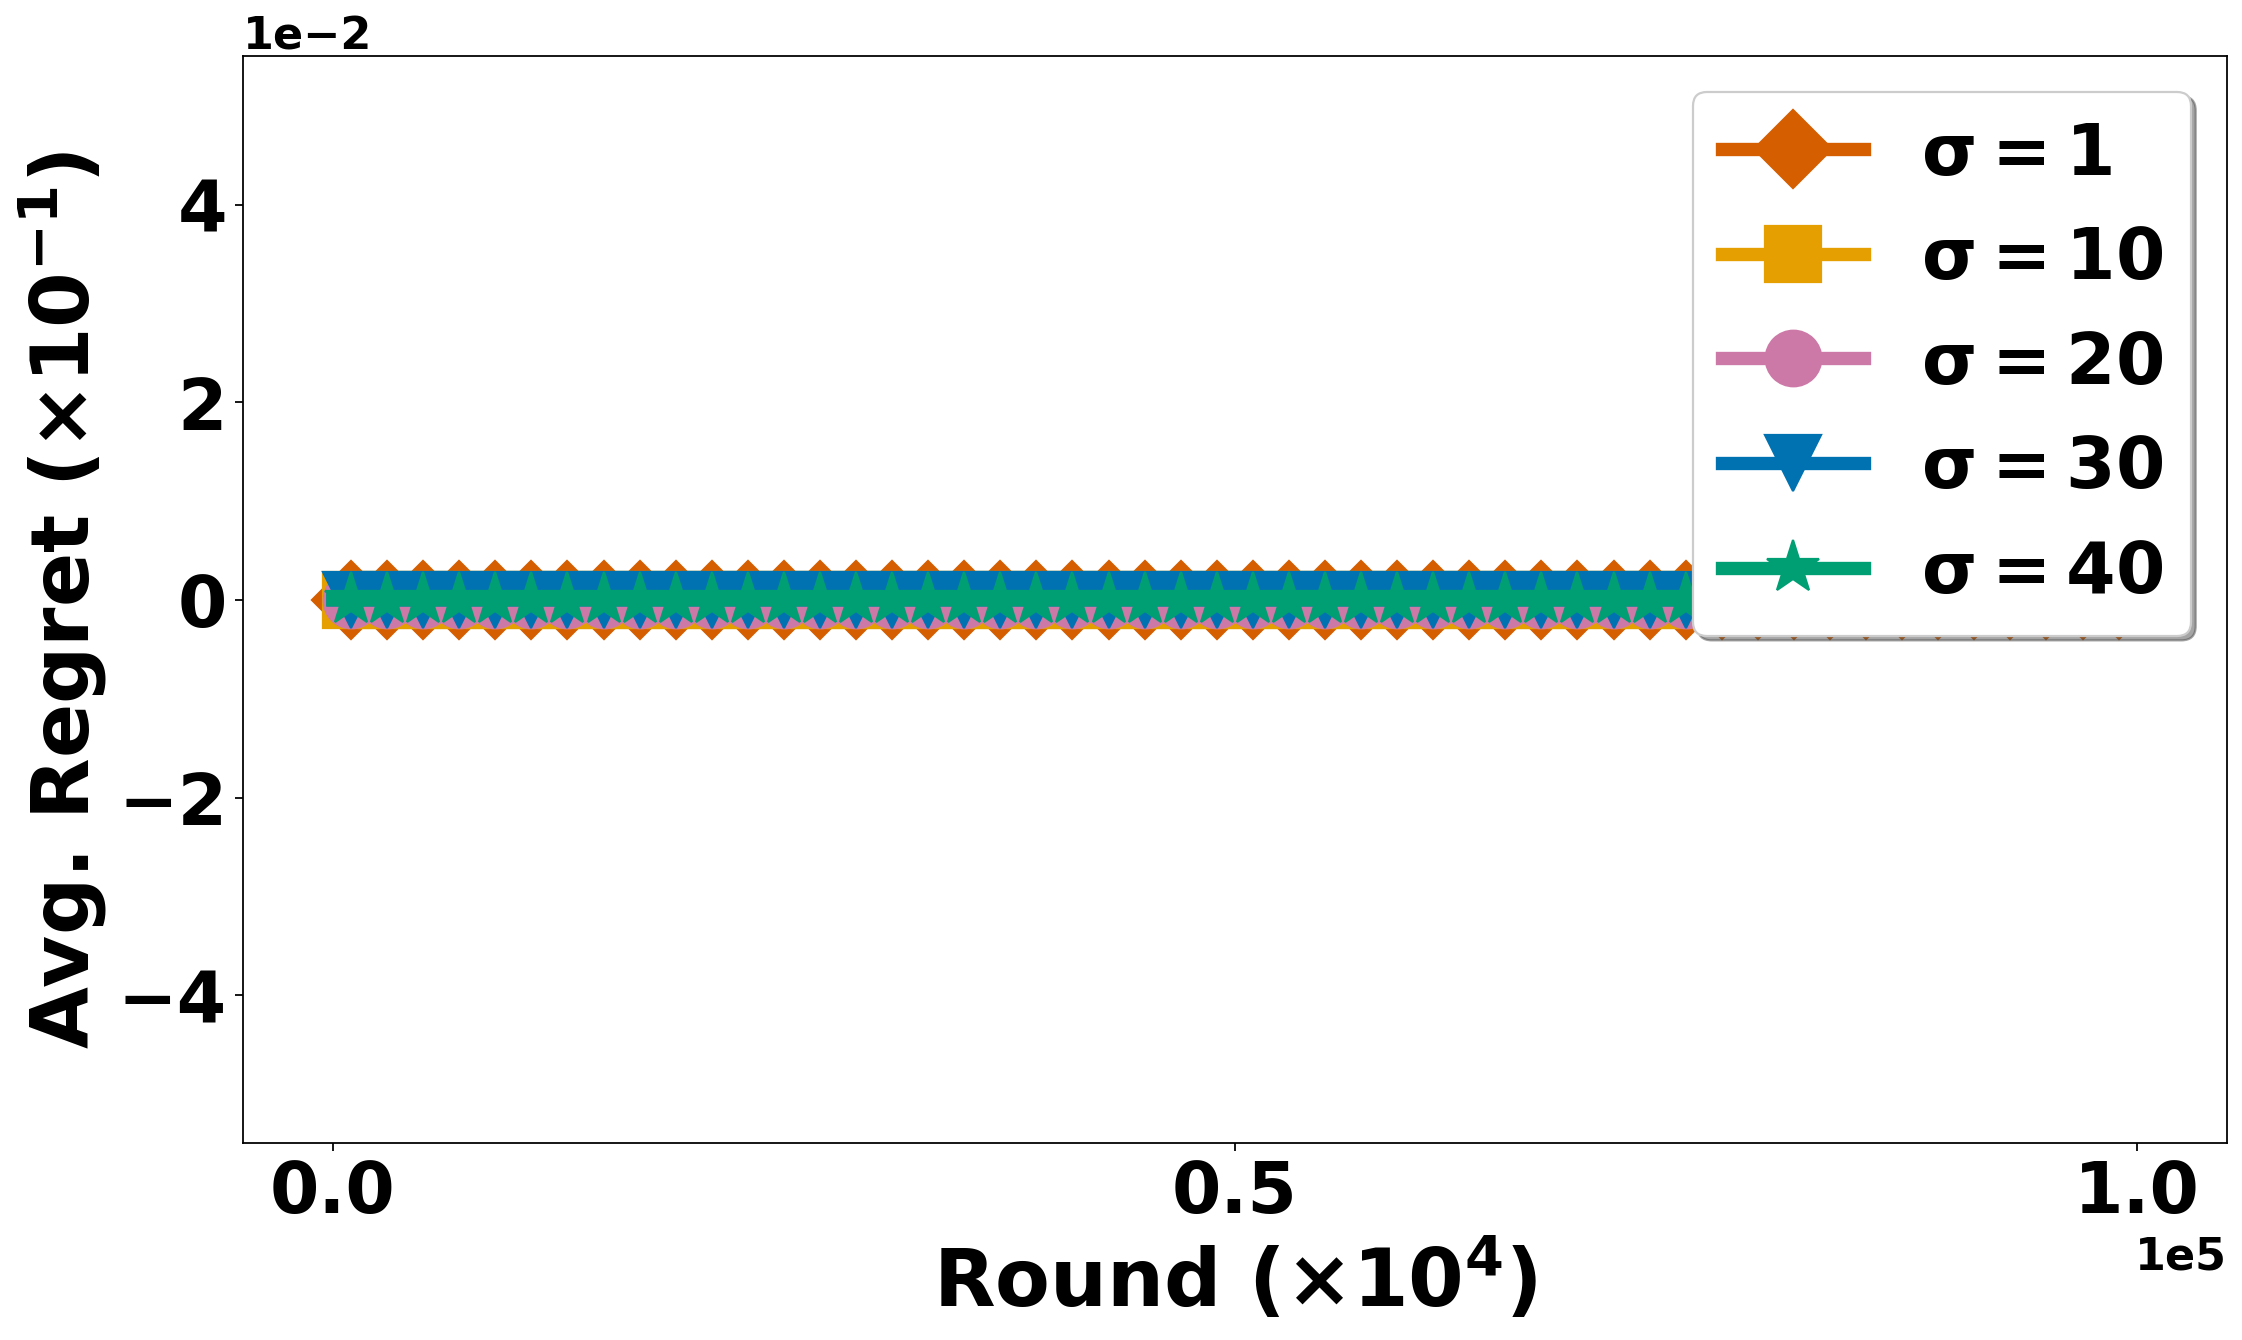

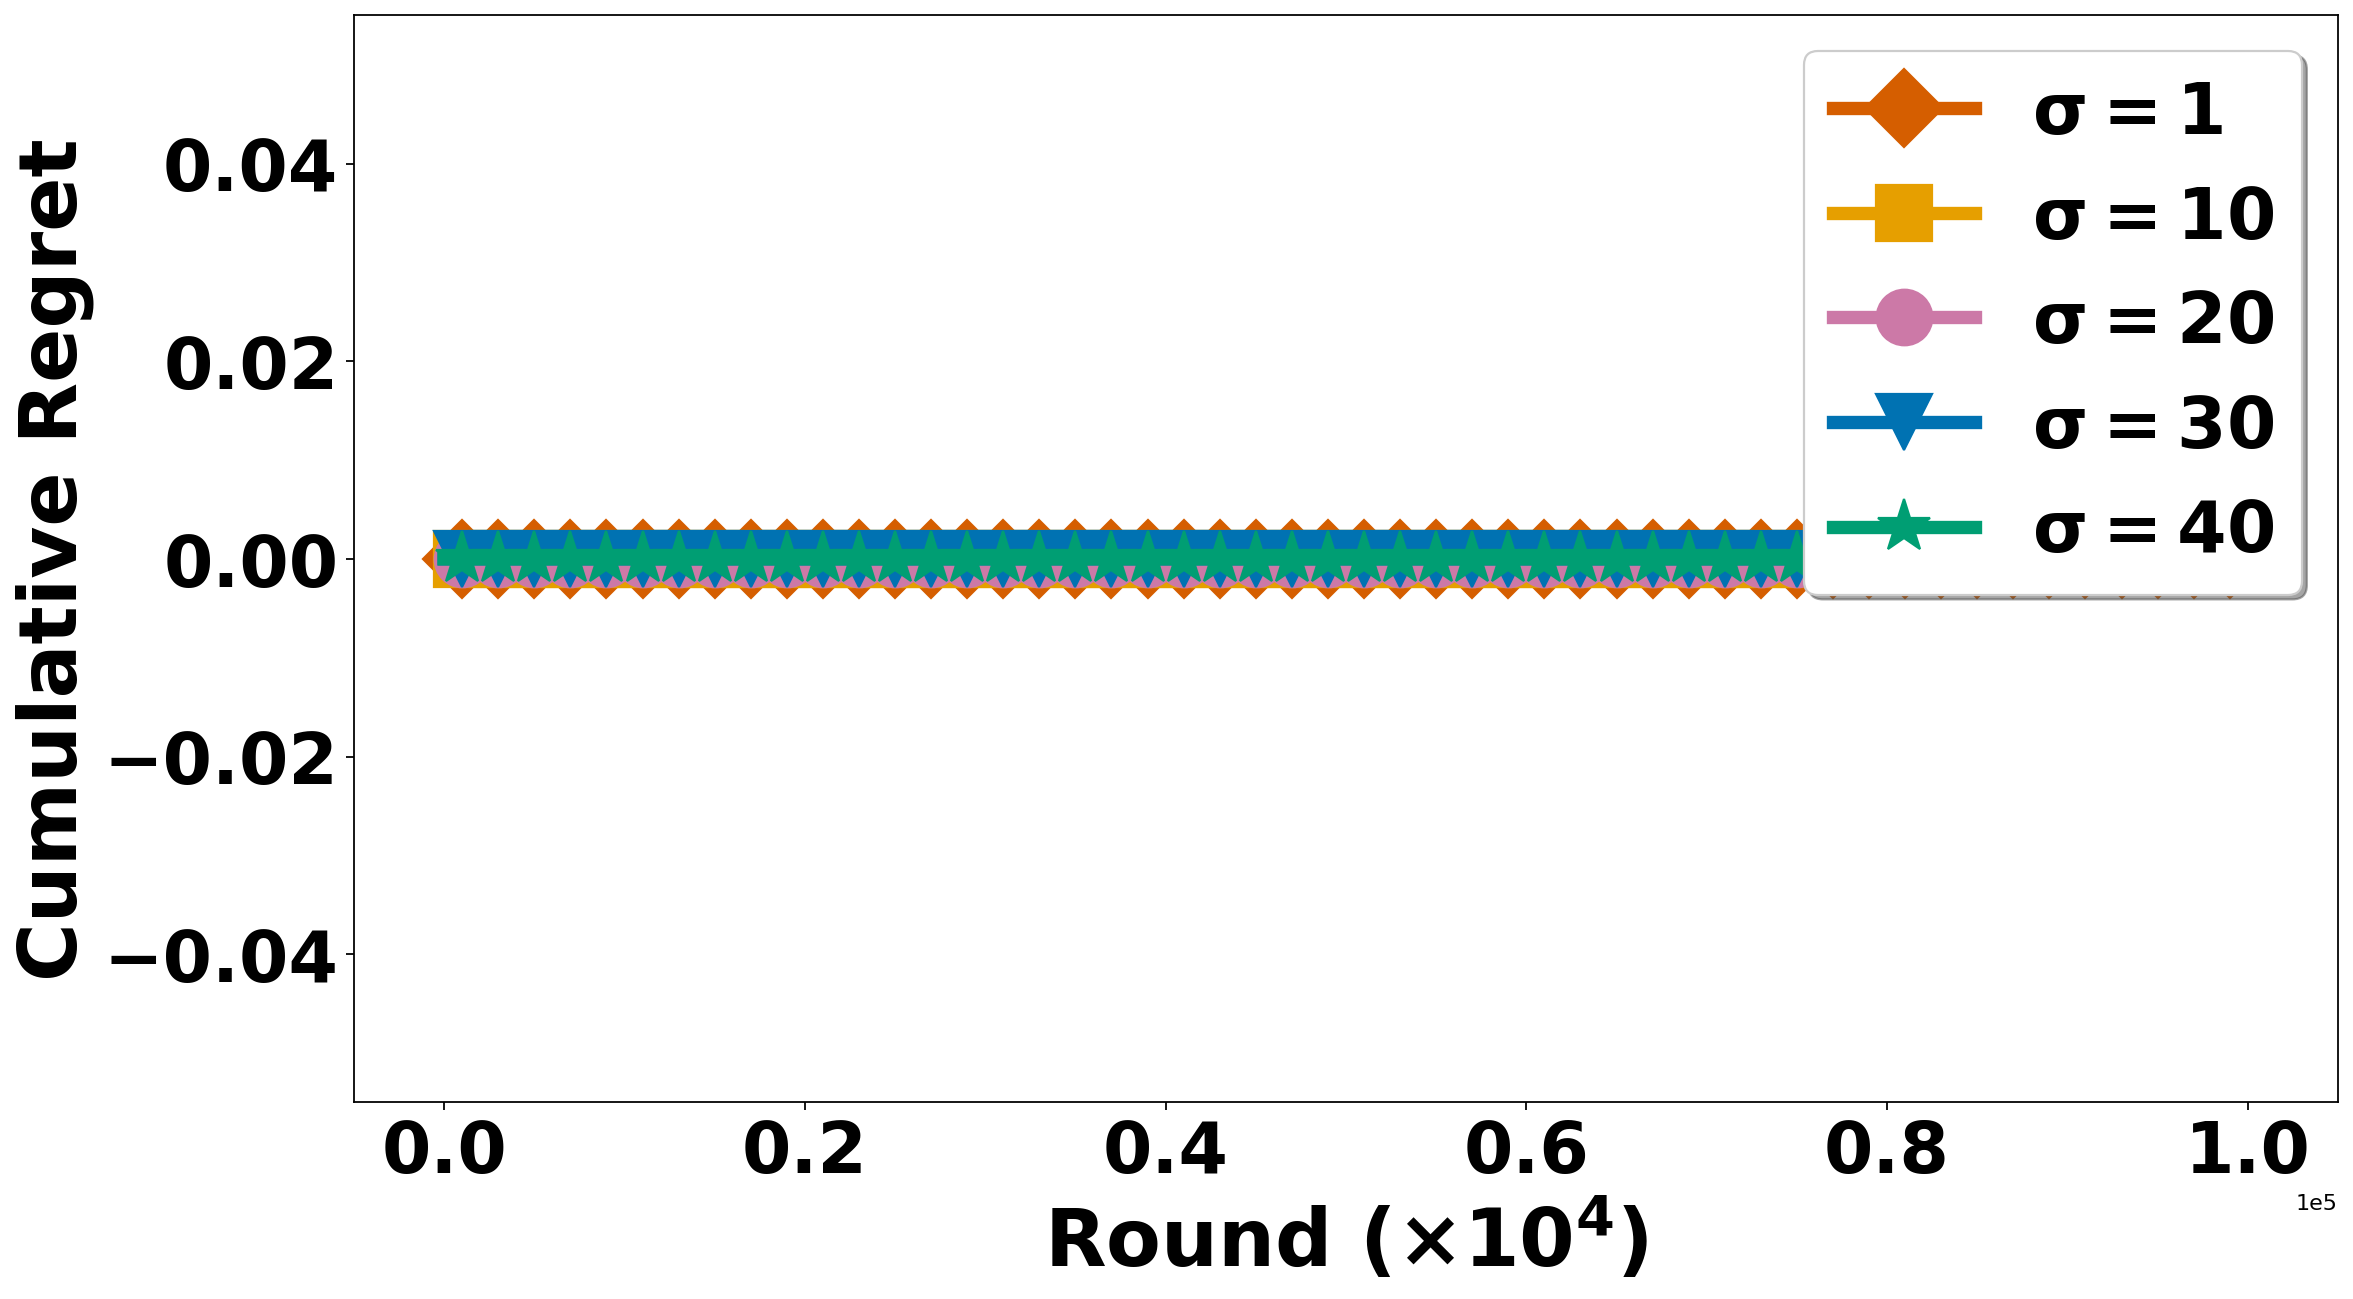

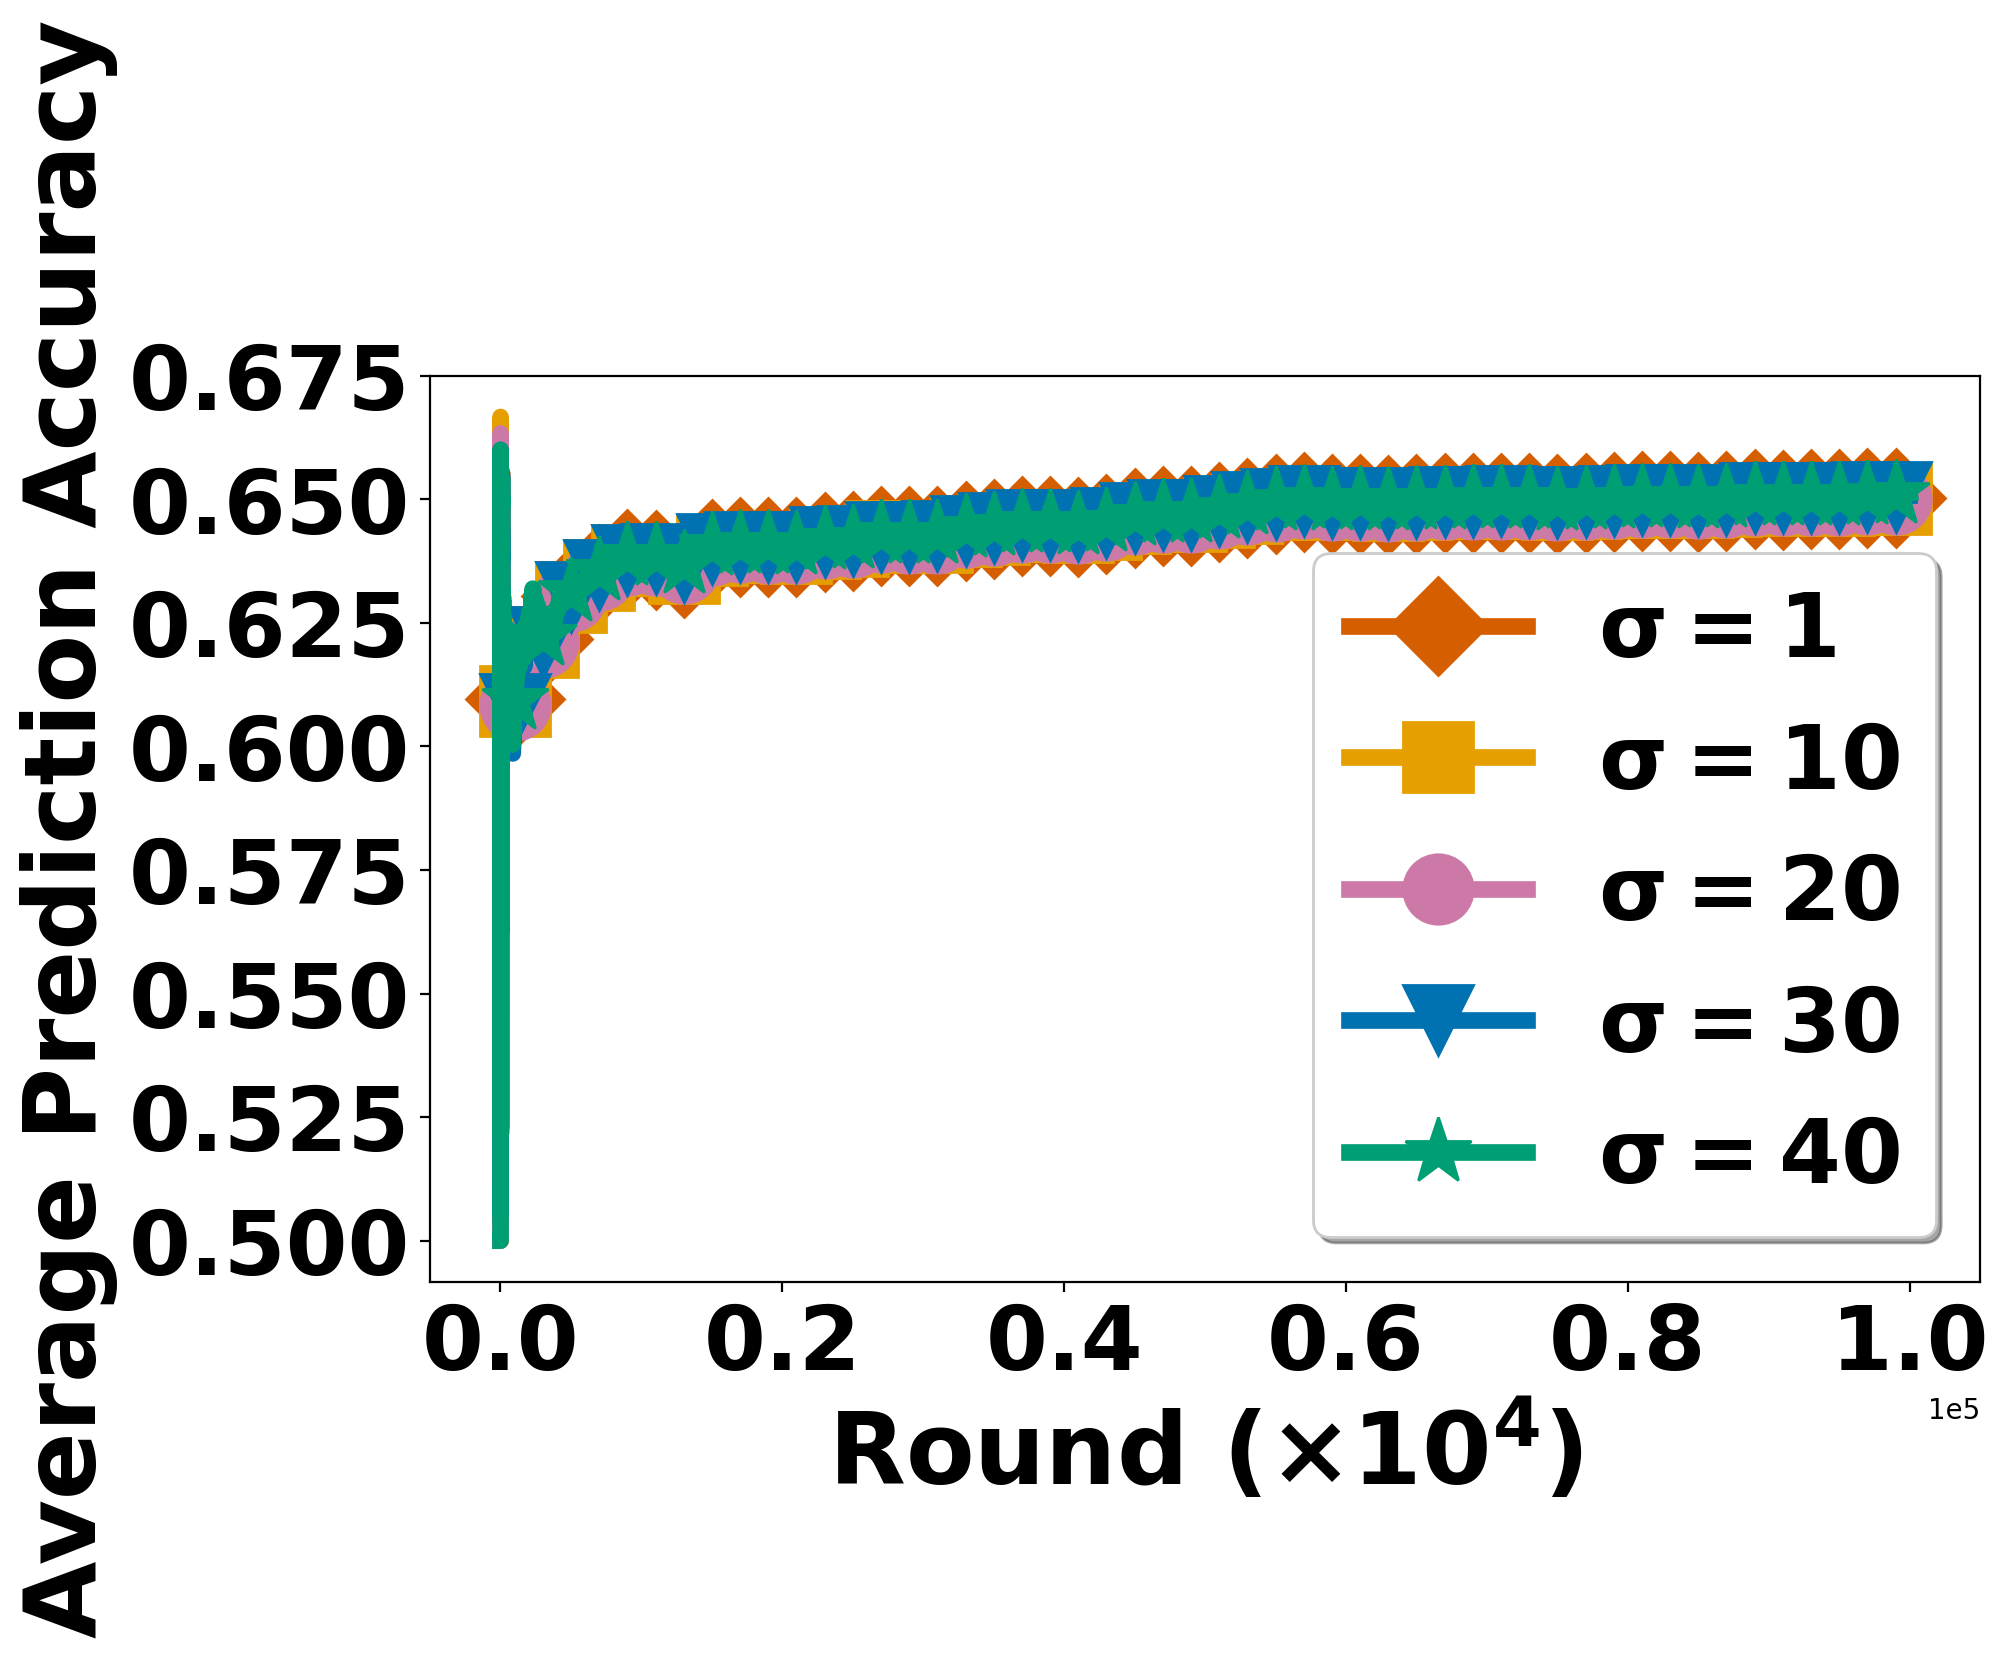

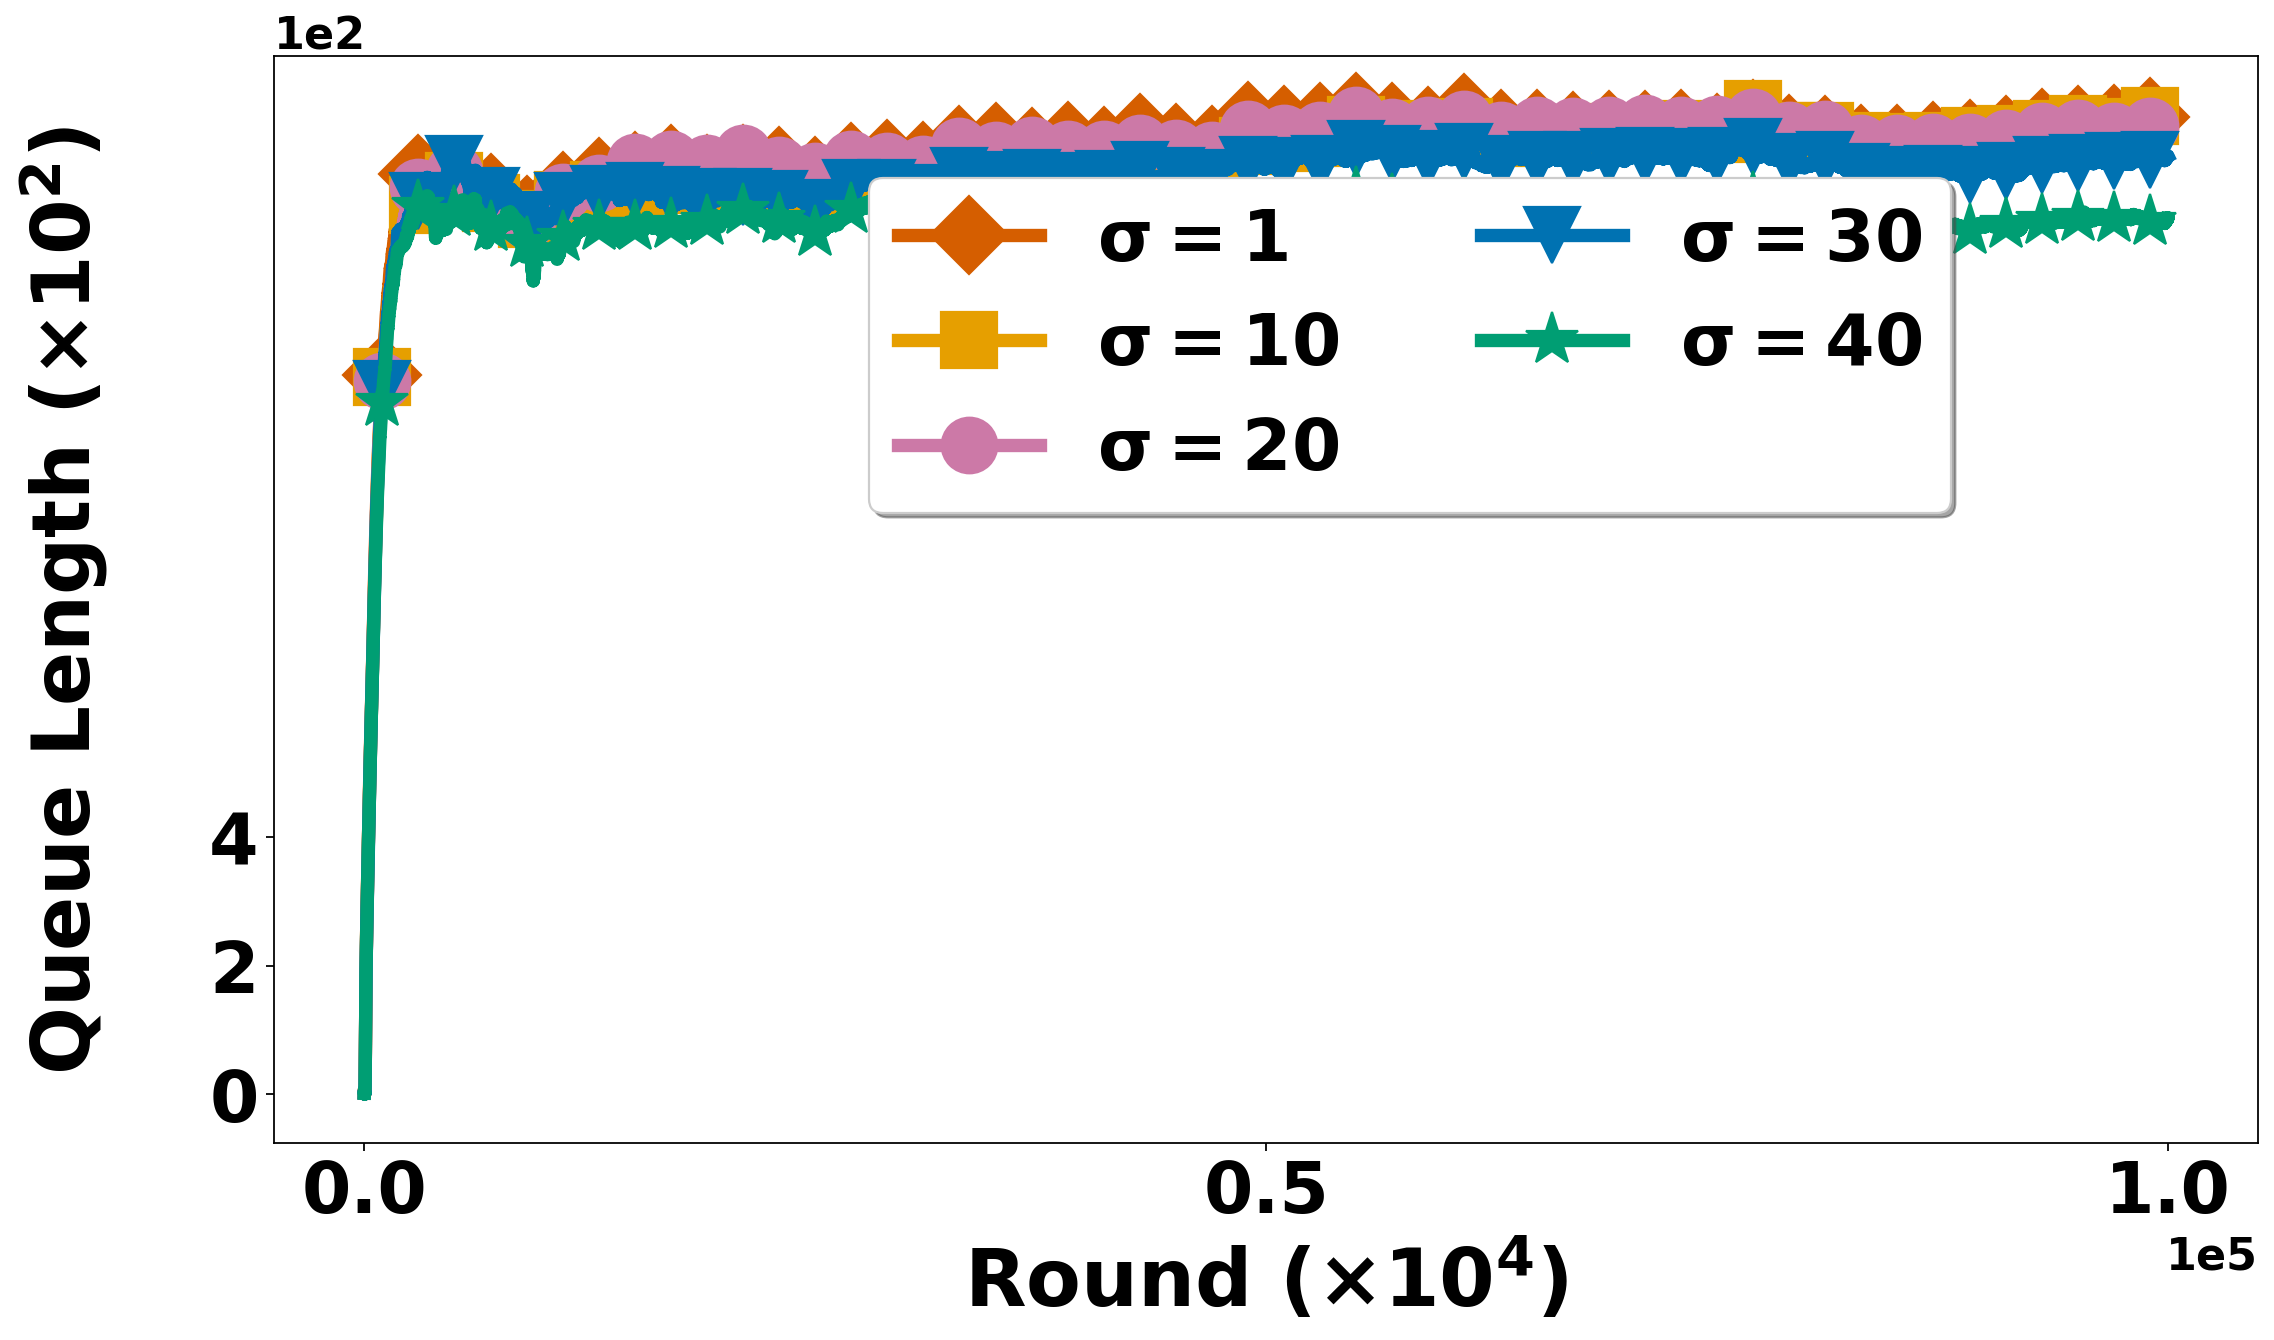

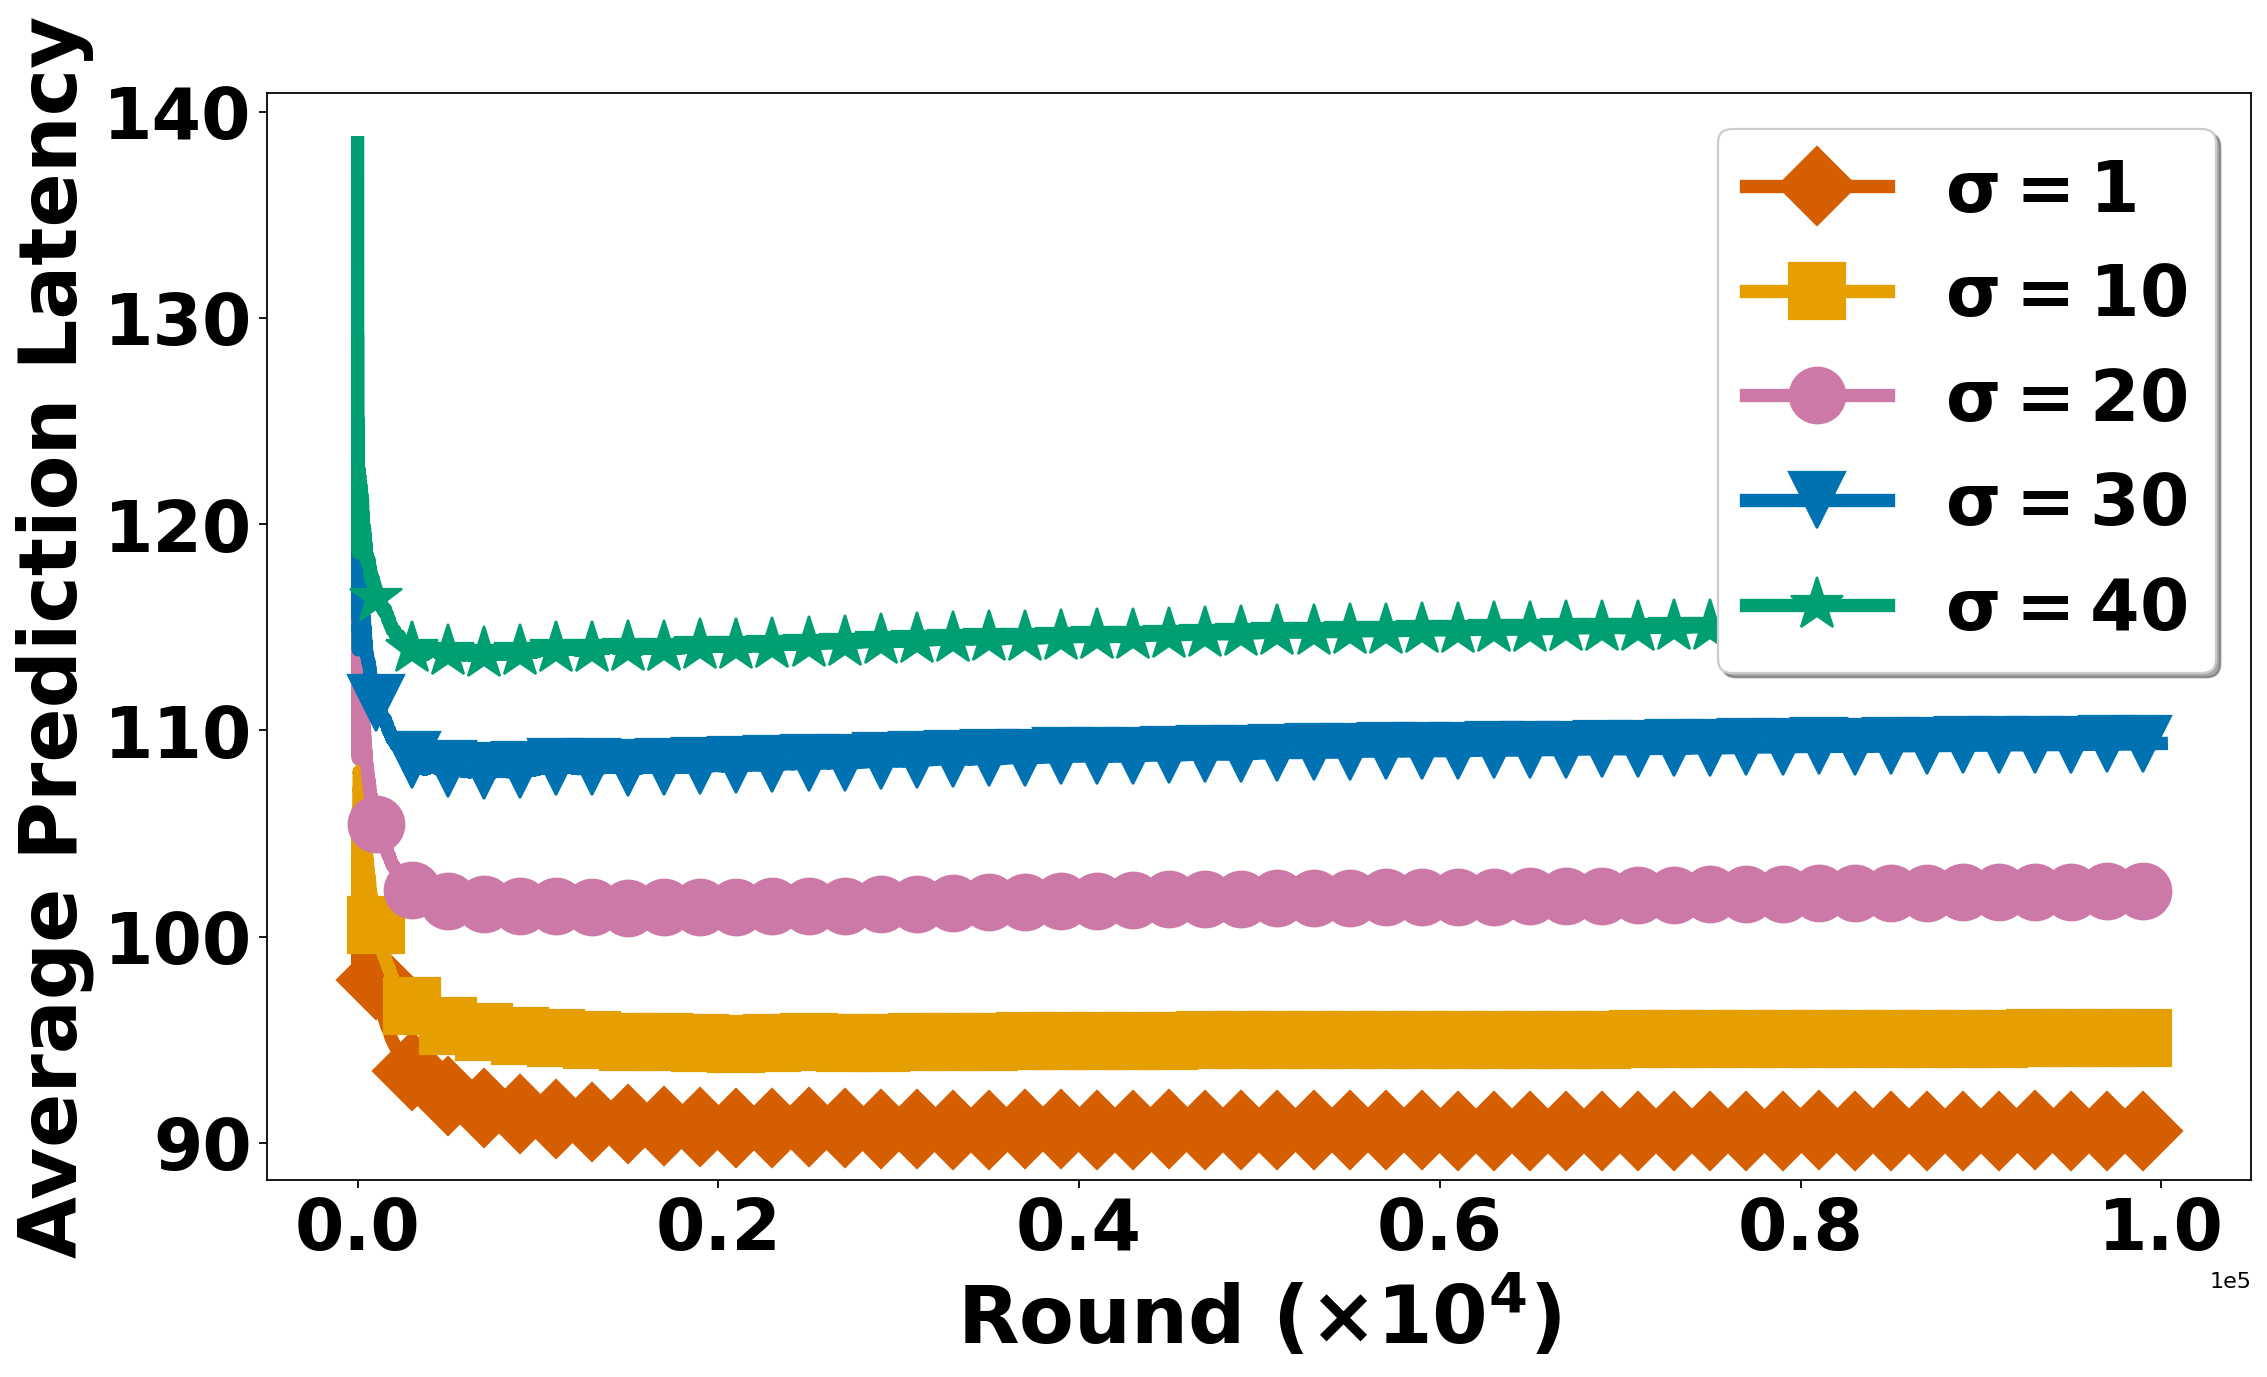

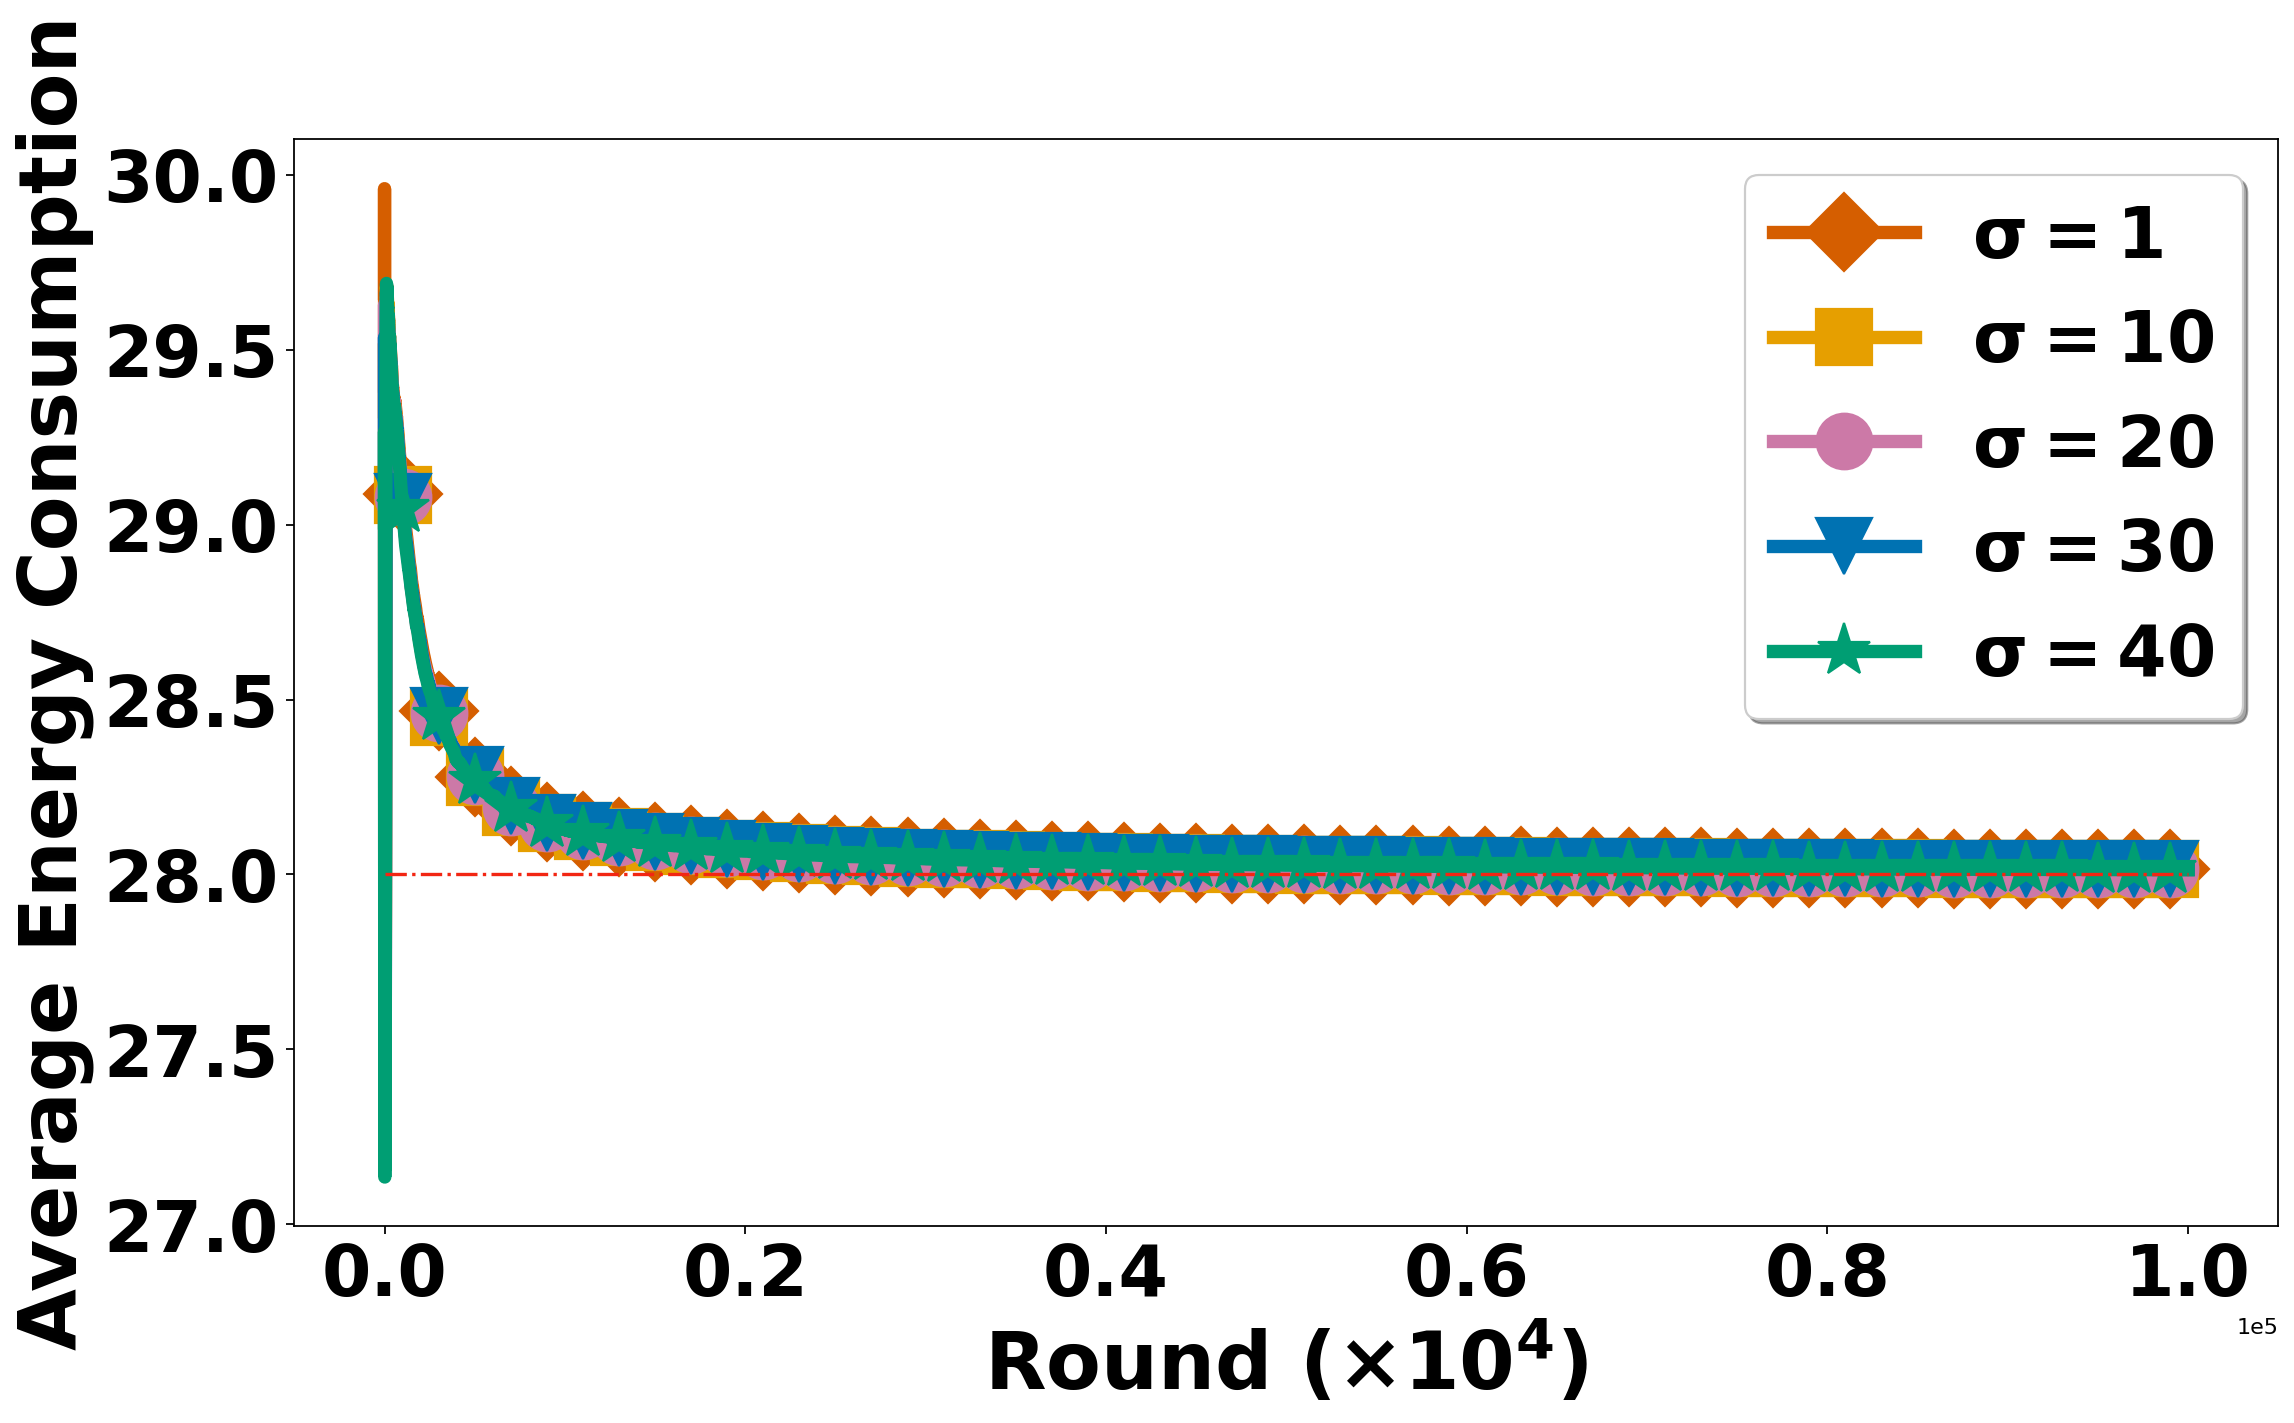

In [10]:
plot()